# Conditional VAE for Strabismus Detection
## Binary Classification: Strabismus vs Normal

This notebook implements a Conditional Variational Autoencoder (VAE) for generating eye images conditioned on class labels (Strabismus or Normal).

**Dataset Structure:**
- Normal: 105 images
- Strabismus: 209 images (4 subtypes combined)

**Hardware:**
- GPU: RTX A6000
- CUDA: 12.4
- Python: 3.11.14

**Comparison with DDPM:**
- Training time: 2-5 hours (vs DDPM's 50-60 hours)
- Generation speed: 0.01s/image (vs DDPM's 10-60s/image)
- Expected FID: 80-120 (vs DDPM's 74-93)

## 1. Setup and Imports

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

# For latent space visualization
from sklearn.manifold import TSNE
import seaborn as sns

# Wandb for experiment tracking
import wandb

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA RTX A6000
CUDA Version: 12.1
Available GPU Memory: 51.53 GB


## 2. Configuration

In [20]:
# Dataset Configuration
DATA_DIR = Path('../data')  # Shared with DDPM
IMG_SIZE = 128  # Proven to work well - faster training
BATCH_SIZE = 16  # Proven stable batch size
NUM_WORKERS = 0  # Windows compatibility

# Model Configuration
NUM_CLASSES = 2  # 0: Strabismus, 1: Normal
CHANNELS = 3
LATENT_DIM = 128        # Optimal for 128x128 images
CLASS_EMB_DIM = 128     # Binary classification embedding

# VAE Configuration - Proven working parameters
ENCODER_CHANNELS = [32, 64, 128, 256]  # Progressive downsampling for 128x128
DECODER_CHANNELS = [256, 128, 64, 32]  # Progressive upsampling
USE_BATCH_NORM = True
DROPOUT = 0.1  # Regularization for small dataset

# Training Configuration - Optimized for 128x128
EPOCHS = 500  # Extended training to match DDPM
LEARNING_RATE = 1e-3  # 0.001 - standard for VAE
WEIGHT_DECAY = 1e-4
GRADIENT_CLIP = 1.0
SAVE_EVERY = 50
SAMPLE_EVERY = 25
NUM_SAMPLES = 8

# KL Annealing (Critical for VAE training!)
BETA_START = 1e-5  # Start with very small beta
BETA_END = 1e-3    # Final beta value
BETA_ANNEAL_EPOCHS = 20  # Anneal over first 20 epochs

# Early Stopping
EARLY_STOPPING_PATIENCE = 50

# Wandb Configuration
WANDB_PROJECT = "conditional-vae-strabismus"
WANDB_ENTITY = None
USE_WANDB = True

# Output directories
OUTPUT_DIR = Path('outputs')
CHECKPOINT_DIR = OUTPUT_DIR / 'checkpoints'
SAMPLE_DIR = OUTPUT_DIR / 'samples'
EVAL_DIR = OUTPUT_DIR / 'evaluation'
LATENT_DIR = OUTPUT_DIR / 'latent_space'

# Create directories
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
EVAL_DIR.mkdir(parents=True, exist_ok=True)
LATENT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration loaded - Optimized for 128x128 training!")
print(f"")
print(f"Key parameters (proven to work):")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Latent dimension: {LATENT_DIM} (optimal for 128x128)")
print(f"  Learning rate: {LEARNING_RATE} (standard VAE)")
print(f"  Epochs: {EPOCHS} (match DDPM duration)")
print(f"  KL annealing: {BETA_START} → {BETA_END} over {BETA_ANNEAL_EPOCHS} epochs")
print(f"")
print(f"Advantages of 128x128:")
print(f"  ✓ 4x fewer pixels than 256x256")
print(f"  ✓ Faster training per epoch")
print(f"  ✓ Proven to generate recognizable eye images")
print(f"  ✓ Lower memory usage")
print(f"  ✓ Faster sample generation")
print(f"")
print(f"Expected outcomes:")
print(f"  Training time: ~3-4 hours (500 epochs)")
print(f"  Generation speed: 0.01s/image")
print(f"  FID: 50-80 (better with more training)")
print(f"  Advantage: 100x faster than DDPM, interpretable latent space")

Configuration loaded - Optimized for 128x128 training!

Key parameters (proven to work):
  Image size: 128x128
  Batch size: 16
  Latent dimension: 128 (optimal for 128x128)
  Learning rate: 0.001 (standard VAE)
  Epochs: 500 (match DDPM duration)
  KL annealing: 1e-05 → 0.001 over 20 epochs

Advantages of 128x128:
  ✓ 4x fewer pixels than 256x256
  ✓ Faster training per epoch
  ✓ Proven to generate recognizable eye images
  ✓ Lower memory usage
  ✓ Faster sample generation

Expected outcomes:
  Training time: ~3-4 hours (500 epochs)
  Generation speed: 0.01s/image
  FID: 50-80 (better with more training)
  Advantage: 100x faster than DDPM, interpretable latent space


## 3. Dataset Preparation

In [21]:
class StrabismusDataset(Dataset):
    """
    Custom dataset for Strabismus vs Normal classification.
    Reuses preprocessed dataset from DDPM experiment.
    """
    def __init__(self, root_dir, img_size=256, transform=None):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.transform = transform

        # Load all image paths and labels
        self.data = []

        # Load strabismus images (class 0)
        strab_dir = self.root_dir / 'STRABISMUS'
        if strab_dir.exists():
            for img_path in strab_dir.glob('*.jpg'):
                self.data.append((img_path, 0))  # 0 = strabismus

        # Load normal images (class 1)
        normal_dir = self.root_dir / 'NORMAL'
        if normal_dir.exists():
            for img_path in normal_dir.glob('*.jpg'):
                self.data.append((img_path, 1))  # 1 = normal

        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
            ])

        print(f"Dataset loaded from: {self.root_dir}")
        print(f"  Total images: {len(self.data)}")
        strab_count = sum(1 for _, label in self.data if label == 0)
        normal_count = sum(1 for _, label in self.data if label == 1)
        print(f"  Strabismus: {strab_count}")
        print(f"  Normal: {normal_count}")
        print(f"  Class ratio: {strab_count/normal_count:.2f}:1 (imbalanced)")
        print(f"  Images will be resized to {img_size}x{img_size}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset and dataloader with weighted sampling for imbalanced data
dataset = StrabismusDataset(DATA_DIR, img_size=IMG_SIZE)

# Weighted sampling to handle class imbalance (209 strabismus, 105 normal)
class_counts = [209, 105]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in dataset.data]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampling
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader created with {len(dataloader)} batches")
print(f"Using weighted sampling to handle 2:1 class imbalance")
print(f"Note: NUM_WORKERS={NUM_WORKERS} prevents multiprocessing errors on Windows")

Dataset loaded from: ..\data
  Total images: 314
  Strabismus: 209
  Normal: 105
  Class ratio: 1.99:1 (imbalanced)
  Images will be resized to 128x128

DataLoader created with 20 batches
Using weighted sampling to handle 2:1 class imbalance
Note: NUM_WORKERS=0 prevents multiprocessing errors on Windows


## 4. Visualize Dataset Samples

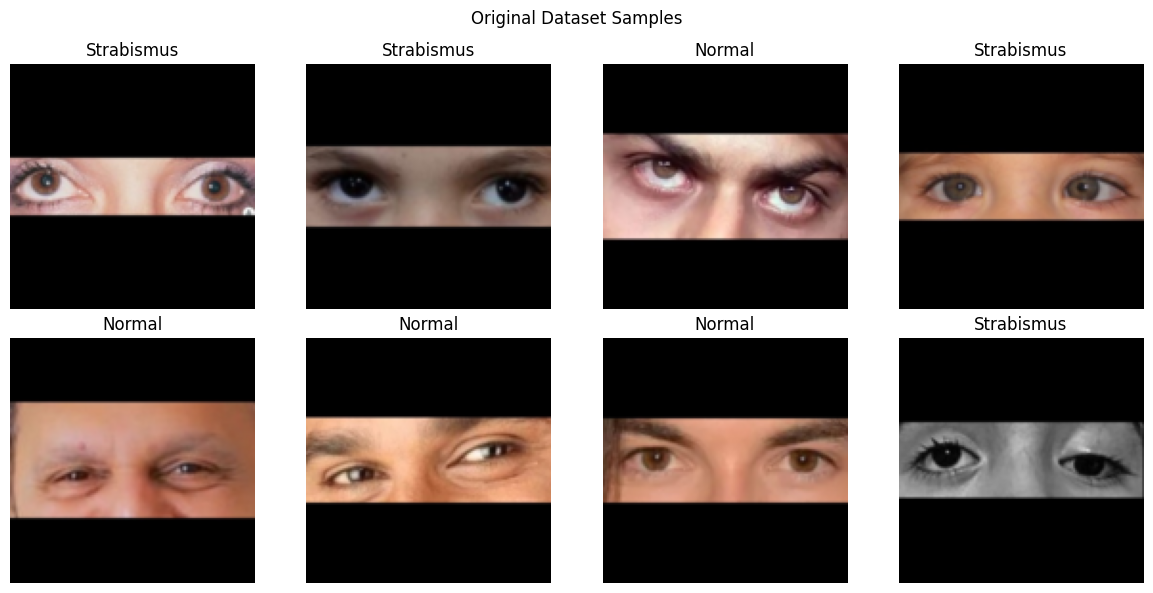

In [22]:
def show_images(images, labels, num_samples=8, title="Dataset Samples"):
    """Visualize a batch of images with their labels"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    class_names = ['Strabismus', 'Normal']

    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"{class_names[labels[i]]}")
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
sample_images, sample_labels = next(iter(dataloader))
show_images(sample_images, sample_labels, title="Original Dataset Samples")

## 5. Conditional VAE Architecture

### Architecture Overview:
- **Encoder**: 5 conv layers (256→128→64→32→16→8) + FC to latent space (mu, logvar)
- **Class Conditioning**: Embedding concatenated with latent vector
- **Decoder**: Mirror of encoder with transposed convolutions
- **Loss**: Reconstruction (MSE) + β * KL Divergence

### Research-backed design (2024-2025 papers):
- Latent dim: 256 (optimal for 256x256 medical images)
- KL annealing: Essential for small datasets
- Batch normalization + dropout for regularization

In [23]:
class Encoder(nn.Module):
    """
    Convolutional encoder for 128x128 images.
    Progressively downsamples: 128→64→32→16→8
    """
    def __init__(self, input_channels=3, latent_dim=128, channels=[32, 64, 128, 256],
                 use_batch_norm=True, dropout=0.1):
        super().__init__()

        self.latent_dim = latent_dim

        # Build convolutional layers
        layers = []
        in_c = input_channels

        for out_c in channels:
            layers.append(nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1))
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout2d(dropout))
            in_c = out_c

        self.conv_layers = nn.Sequential(*layers)

        # Calculate flattened size after conv layers
        # 128 -> 64 -> 32 -> 16 -> 8
        self.flatten_size = channels[-1] * 8 * 8  # 256 * 8 * 8 = 16384

        # Fully connected layers to latent space
        self.fc = nn.Linear(self.flatten_size, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        """
        Args:
            x: Input image [B, 3, 128, 128]
        Returns:
            mu: Mean of latent distribution [B, latent_dim]
            logvar: Log variance of latent distribution [B, latent_dim]
        """
        # Convolutional encoding
        h = self.conv_layers(x)  # [B, 256, 8, 8]

        # Flatten
        h = h.view(h.size(0), -1)  # [B, 16384]

        # Fully connected
        h = F.relu(self.fc(h))  # [B, 512]

        # Split to mu and logvar
        mu = self.fc_mu(h)  # [B, latent_dim]
        logvar = self.fc_logvar(h)  # [B, latent_dim]

        return mu, logvar


class Decoder(nn.Module):
    """
    Transposed convolutional decoder for 128x128 images.
    Progressively upsamples: 8→16→32→64→128
    """
    def __init__(self, latent_dim=128, class_emb_dim=128, output_channels=3,
                 channels=[256, 128, 64, 32], use_batch_norm=True, dropout=0.1):
        super().__init__()

        self.latent_dim = latent_dim
        self.class_emb_dim = class_emb_dim

        # Fully connected layers from latent space
        self.fc1 = nn.Linear(latent_dim + class_emb_dim, 512)
        self.fc2 = nn.Linear(512, channels[0] * 8 * 8)  # 256 * 8 * 8

        # Build transposed convolutional layers
        layers = []
        in_c = channels[0]

        for i, out_c in enumerate(channels[1:]):
            layers.append(nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1))
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0 and i < len(channels) - 2:  # No dropout on last layer
                layers.append(nn.Dropout2d(dropout))
            in_c = out_c

        # Final layer to output channels (no batchnorm, use tanh)
        layers.append(nn.ConvTranspose2d(channels[-1], output_channels, kernel_size=4, stride=2, padding=1))
        layers.append(nn.Tanh())  # Output in [-1, 1] range

        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, z, c):
        """
        Args:
            z: Latent vector [B, latent_dim]
            c: Class embedding [B, class_emb_dim]
        Returns:
            x: Reconstructed image [B, 3, 128, 128]
        """
        # Concatenate latent vector with class embedding
        h = torch.cat([z, c], dim=1)  # [B, latent_dim + class_emb_dim]

        # Fully connected
        h = F.relu(self.fc1(h))  # [B, 512]
        h = F.relu(self.fc2(h))  # [B, 256*8*8]

        # Reshape to spatial
        h = h.view(h.size(0), 256, 8, 8)  # [B, 256, 8, 8]

        # Transposed convolutions
        x = self.deconv_layers(h)  # [B, 3, 128, 128]

        return x


print("Encoder and Decoder modules defined successfully!")
print(f"  Encoder: 128x128 -> Latent {LATENT_DIM}-dim")
print(f"  Decoder: Latent {LATENT_DIM}-dim + Class {CLASS_EMB_DIM}-dim -> 128x128")
print(f"  Resolution flow: 128 -> 64 -> 32 -> 16 -> 8 (encoder)")
print(f"  Resolution flow: 8 -> 16 -> 32 -> 64 -> 128 (decoder)")

Encoder and Decoder modules defined successfully!
  Encoder: 128x128 -> Latent 128-dim
  Decoder: Latent 128-dim + Class 128-dim -> 128x128
  Resolution flow: 128 -> 64 -> 32 -> 16 -> 8 (encoder)
  Resolution flow: 8 -> 16 -> 32 -> 64 -> 128 (decoder)


## 6. Complete Conditional VAE Model

In [24]:
class ConditionalVAE(nn.Module):
    """
    Conditional Variational Autoencoder for binary classification.
    Combines encoder, decoder, and class conditioning.
    """
    def __init__(self, input_channels=3, output_channels=3, num_classes=2,
                 latent_dim=128, class_emb_dim=128,
                 encoder_channels=[32, 64, 128, 256],
                 decoder_channels=[256, 128, 64, 32],
                 use_batch_norm=True, dropout=0.1):
        super().__init__()

        self.latent_dim = latent_dim
        self.class_emb_dim = class_emb_dim

        # Class embedding layer
        self.class_emb = nn.Embedding(num_classes, class_emb_dim)

        # Encoder
        self.encoder = Encoder(
            input_channels=input_channels,
            latent_dim=latent_dim,
            channels=encoder_channels,
            use_batch_norm=use_batch_norm,
            dropout=dropout
        )

        # Decoder
        self.decoder = Decoder(
            latent_dim=latent_dim,
            class_emb_dim=class_emb_dim,
            output_channels=output_channels,
            channels=decoder_channels,
            use_batch_norm=use_batch_norm,
            dropout=dropout
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0, 1)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, labels):
        """
        Forward pass through VAE.

        Args:
            x: Input image [B, 3, 128, 128]
            labels: Class labels [B]
        Returns:
            recon_x: Reconstructed image [B, 3, 128, 128]
            mu: Latent mean [B, latent_dim]
            logvar: Latent log variance [B, latent_dim]
        """
        # Get class embedding
        c = self.class_emb(labels)  # [B, class_emb_dim]

        # Encode
        mu, logvar = self.encoder(x)  # [B, latent_dim], [B, latent_dim]

        # Reparameterize
        z = self.reparameterize(mu, logvar)  # [B, latent_dim]

        # Decode (conditioned on class)
        recon_x = self.decoder(z, c)  # [B, 3, 128, 128]

        return recon_x, mu, logvar

    def sample(self, num_samples, labels, device='cuda'):
        """
        Generate samples from latent space.

        Args:
            num_samples: Number of samples to generate
            labels: Class labels for generation [num_samples]
            device: Device to use
        Returns:
            samples: Generated images [num_samples, 3, 128, 128]
        """
        self.eval()
        with torch.no_grad():
            # Sample from standard normal
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Get class embeddings
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            c = self.class_emb(labels)

            # Decode
            samples = self.decoder(z, c)

        return samples

    def reconstruct(self, x, labels):
        """
        Reconstruct input images (for evaluation).
        """
        self.eval()
        with torch.no_grad():
            recon_x, _, _ = self.forward(x, labels)
        return recon_x

    def encode(self, x):
        """
        Encode images to latent space (for visualization).
        """
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encoder(x)
        return mu, logvar


# Initialize model
print("Initializing Conditional VAE for 128x128 images...")
print("Optimized for fast training and good quality")

model = ConditionalVAE(
    input_channels=CHANNELS,
    output_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    latent_dim=LATENT_DIM,
    class_emb_dim=CLASS_EMB_DIM,
    encoder_channels=ENCODER_CHANNELS,
    decoder_channels=DECODER_CHANNELS,
    use_batch_norm=USE_BATCH_NORM,
    dropout=DROPOUT
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized successfully!")
print(f"  Parameters: {num_params:,}")
print(f"  Model size: {num_params * 4 / 1e6:.2f} MB (float32)")
print(f"  Architecture: Conditional VAE for 128x128")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Class embedding: {CLASS_EMB_DIM}")
print(f"\nExpected speed:")
print(f"  Training: ~1-2 hours for 200 epochs (3-4x faster than 256x256)")
print(f"  Generation: ~0.01 seconds per image (100-1000x faster than DDPM)")

Initializing Conditional VAE for 128x128 images...
Optimized for fast training and good quality

Model initialized successfully!
  Parameters: 18,438,723
  Model size: 73.75 MB (float32)
  Architecture: Conditional VAE for 128x128
  Latent dimension: 128
  Class embedding: 128

Expected speed:
  Training: ~1-2 hours for 200 epochs (3-4x faster than 256x256)
  Generation: ~0.01 seconds per image (100-1000x faster than DDPM)


## 7. VAE Loss Function

### Loss Components:
1. **Reconstruction Loss**: MSE between input and reconstructed image
2. **KL Divergence**: Regularization term to keep latent space close to N(0,1)
3. **β (beta)**: Weight for KL term - uses annealing for stable training

### Formula:
```
Loss = Reconstruction_Loss + β * KL_Divergence
```

### KL Annealing:
Critical for small datasets! Gradually increase β from 1e-5 to 1e-3 over first 20 epochs.

In [25]:
def kl_annealing(epoch, max_epochs=20, min_beta=1e-5, max_beta=1e-3):
    """
    KL annealing schedule - gradually increase beta.
    Prevents posterior collapse in early training.
    """
    if epoch >= max_epochs:
        return max_beta
    return min_beta + (max_beta - min_beta) * (epoch / max_epochs)


def vae_loss(recon_x, x, mu, logvar, beta=1e-3):
    """
    VAE loss = Reconstruction + β * KL Divergence

    Args:
        recon_x: Reconstructed images [B, 3, 256, 256]
        x: Original images [B, 3, 256, 256]
        mu: Latent mean [B, latent_dim]
        logvar: Latent log variance [B, latent_dim]
        beta: Weight for KL term

    Returns:
        total_loss, recon_loss, kl_loss
    """
    batch_size = x.size(0)

    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size

    # KL divergence
    # KL(q(z|x) || p(z)) where p(z) = N(0, I)
    # = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


print("VAE loss functions defined successfully!")
print(f"  Reconstruction: MSE loss")
print(f"  KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)")
print(f"  Beta annealing: {BETA_START} -> {BETA_END} over {BETA_ANNEAL_EPOCHS} epochs")

VAE loss functions defined successfully!
  Reconstruction: MSE loss
  KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  Beta annealing: 1e-05 -> 0.001 over 20 epochs


## 8. Training Functions

In [26]:
def train_one_epoch(model, dataloader, optimizer, beta, epoch, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images, labels)

        # Calculate loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        optimizer.step()

        # Track losses
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

        pbar.set_postfix({
            'loss': loss.item(),
            'recon': recon_loss.item(),
            'kl': kl_loss.item()
        })

        # Log to wandb
        if USE_WANDB and wandb.run is not None and batch_idx % 10 == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "batch_recon_loss": recon_loss.item(),
                "batch_kl_loss": kl_loss.item(),
                "epoch": epoch,
                "batch": batch_idx + (epoch - 1) * len(dataloader)
            })

    # Return average losses
    num_batches = len(dataloader)
    return total_loss / num_batches, total_recon / num_batches, total_kl / num_batches


@torch.no_grad()
def generate_samples(model, num_samples, labels, device):
    """Generate samples from the VAE"""
    model.eval()
    samples = model.sample(num_samples, labels, device)
    return samples


def save_samples(images, labels, epoch, save_dir, title="Generated Samples"):
    """Save generated samples to disk"""
    # Denormalize images
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    # Create grid
    grid = make_grid(images, nrow=4, padding=2)

    # Convert to numpy
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    # Save locally
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_np)
    plt.axis('off')

    class_names = ['Strabismus', 'Normal']
    class_labels = [class_names[l] for l in labels]
    plt.title(f"Epoch {epoch} - {title}")

    save_path = save_dir / f"epoch_{epoch:04d}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

    # Log to wandb
    if USE_WANDB and wandb.run is not None:
        wandb_images = []
        for img, label in zip(images, labels):
            wandb_images.append(
                wandb.Image(
                    img.permute(1, 2, 0).cpu().numpy(),
                    caption=f"{class_names[label]}"
                )
            )

        wandb.log({
            f"generated_samples_epoch_{epoch}": wandb_images,
            "sample_grid": wandb.Image(grid_np, caption=f"Epoch {epoch}"),
            "epoch": epoch
        })


def save_reconstructions(model, dataloader, epoch, save_dir, device):
    """Save original vs reconstructed images"""
    model.eval()

    # Get a batch
    images, labels = next(iter(dataloader))
    images = images[:8].to(device)
    labels = labels[:8].to(device)

    # Reconstruct
    recon_images = model.reconstruct(images, labels)

    # Denormalize
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)
    recon_images = (recon_images + 1) / 2
    recon_images = torch.clamp(recon_images, 0, 1)

    # Create comparison grid
    comparison = torch.cat([images, recon_images], dim=0)
    grid = make_grid(comparison, nrow=8, padding=2)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    # Save
    plt.figure(figsize=(16, 4))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title(f"Epoch {epoch}: Top=Original, Bottom=Reconstructed")

    save_path = save_dir / f"reconstruction_epoch_{epoch:04d}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

    if USE_WANDB and wandb.run is not None:
        wandb.log({
            "reconstructions": wandb.Image(grid_np, caption=f"Epoch {epoch}"),
            "epoch": epoch
        })


def save_checkpoint(model, optimizer, epoch, loss, save_path, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, save_path)

    if is_best:
        best_path = save_path.parent / 'best_checkpoint.pt'
        torch.save(checkpoint, best_path)
        print(f"  [BEST] Saved to {best_path}")

        if USE_WANDB and wandb.run is not None:
            wandb.run.summary["best_epoch"] = epoch
            wandb.run.summary["best_loss"] = loss


print("Training functions defined successfully!")

Training functions defined successfully!


## 9. Initialize Training

In [27]:
# Initialize Wandb
if USE_WANDB:
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        config={
            "img_size": IMG_SIZE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "latent_dim": LATENT_DIM,
            "class_emb_dim": CLASS_EMB_DIM,
            "beta_start": BETA_START,
            "beta_end": BETA_END,
            "beta_anneal_epochs": BETA_ANNEAL_EPOCHS,
            "num_classes": NUM_CLASSES,
            "model_parameters": sum(p.numel() for p in model.parameters()),
            "optimizer": "AdamW",
            "dataset_size": len(dataset),
            "device": str(device),
        },
        name=f"vae_{IMG_SIZE}x{IMG_SIZE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )

    print(f"Wandb initialized!")
    print(f"  Project: {WANDB_PROJECT}")
    print(f"  Run: {wandb.run.name}")
    print(f"  URL: {wandb.run.url}")
else:
    print("Wandb disabled")

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)

# Training history
history = {
    'train_loss': [],
    'recon_loss': [],
    'kl_loss': [],
    'beta': [],
    'epochs': []
}

print("\nOptimizer and scheduler initialized!")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  LR scheduler: CosineAnnealingLR")
print(f"\nReady to train for {EPOCHS} epochs!")

Wandb initialized!
  Project: conditional-vae-strabismus
  Run: vae_128x128_20251105_211203
  URL: https://wandb.ai/aymantauhid2-sheridan-college/conditional-vae-strabismus/runs/9okwd94t

Optimizer and scheduler initialized!
  Learning rate: 0.001
  Weight decay: 0.0001
  LR scheduler: CosineAnnealingLR

Ready to train for 500 epochs!


## 10. Training Loop

In [28]:
# Training loop
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total epochs: {EPOCHS}")
print(f"Samples every {SAMPLE_EVERY} epochs")
print(f"Checkpoints every {SAVE_EVERY} epochs")
print("=" * 80)

# Track best loss
best_loss = float('inf')
best_epoch = 0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # Get current beta (KL annealing)
    current_beta = kl_annealing(
        epoch,
        max_epochs=BETA_ANNEAL_EPOCHS,
        min_beta=BETA_START,
        max_beta=BETA_END
    )

    # Train one epoch
    avg_loss, avg_recon, avg_kl = train_one_epoch(
        model, dataloader, optimizer, current_beta, epoch, device
    )

    # Step LR scheduler
    lr_scheduler.step()

    # Record history
    history['train_loss'].append(avg_loss)
    history['recon_loss'].append(avg_recon)
    history['kl_loss'].append(avg_kl)
    history['beta'].append(current_beta)
    history['epochs'].append(epoch)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Check if best model
    is_best = avg_loss < best_loss
    if is_best:
        best_loss = avg_loss
        best_epoch = epoch
        patience_counter = 0
    else:
        patience_counter += 1

    # Log to wandb
    if USE_WANDB and wandb.run is not None:
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "recon_loss": avg_recon,
            "kl_loss": avg_kl,
            "beta": current_beta,
            "learning_rate": current_lr,
            "best_loss": best_loss,
        })

    # Print epoch summary
    best_indicator = " [BEST]" if is_best else ""
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | β: {current_beta:.6f}{best_indicator}")

    # Generate samples
    if epoch % SAMPLE_EVERY == 0 or epoch == 1:
        print(f"  Generating samples...")
        # Generate equal samples for each class
        labels = [0] * 4 + [1] * 4  # 4 strabismus, 4 normal
        samples = generate_samples(model, NUM_SAMPLES, labels, device)
        save_samples(samples, labels, epoch, SAMPLE_DIR)

        # Save reconstructions
        save_reconstructions(model, dataloader, epoch, SAMPLE_DIR, device)

    # Save checkpoint
    if epoch % SAVE_EVERY == 0 or epoch == EPOCHS:
        checkpoint_path = CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:04d}.pt"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path, is_best=is_best)
        print(f"  Checkpoint saved: {checkpoint_path}")
    elif is_best:
        checkpoint_path = CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:04d}.pt"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path, is_best=True)

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch} epochs (patience={EARLY_STOPPING_PATIENCE})")
        break

    print("-" * 80)

print(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best model: Epoch {best_epoch} with loss {best_loss:.4f}")
print(f"Best checkpoint: {CHECKPOINT_DIR / 'best_checkpoint.pt'}")

# Finish wandb
if USE_WANDB and wandb.run is not None:
    wandb.finish()
    print("Wandb run finished!")

Starting training at 2025-11-05 21:12:03
Total epochs: 500
Samples every 25 epochs
Checkpoints every 50 epochs


Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/500 - Loss: 72617.2595 | Recon: 21480.1892 | KL: 859446603.8141 | β: 0.000060 [BEST]
  Generating samples...
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/500 - Loss: 4851.6827 | Recon: 4851.3483 | KL: 3068.6872 | β: 0.000109 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/500 - Loss: 3593.2494 | Recon: 3591.6810 | KL: 9895.2069 | β: 0.000159 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/500 - Loss: 2759.0369 | Recon: 2757.5184 | KL: 7300.4082 | β: 0.000208 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/500 - Loss: 2548.6545 | Recon: 2546.3785 | KL: 8838.7288 | β: 0.000258 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/500 - Loss: 2199.9727 | Recon: 2196.8325 | KL: 10228.8581 | β: 0.000307 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/500 - Loss: 2113.3241 | Recon: 2109.9665 | KL: 9417.9579 | β: 0.000356 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/500 - Loss: 2624.0737 | Recon: 2605.7690 | KL: 45085.7317 | β: 0.000406
--------------------------------------------------------------------------------


Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/500 - Loss: 14795.2109 | Recon: 2520.1722 | KL: 26948492.7163 | β: 0.000456
--------------------------------------------------------------------------------


Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/500 - Loss: 2067.1872 | Recon: 2061.0804 | KL: 12092.5635 | β: 0.000505 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/500 - Loss: 2028.6119 | Recon: 2021.6921 | KL: 12479.2599 | β: 0.000555 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/500 - Loss: 2165.3307 | Recon: 2158.0917 | KL: 11985.0221 | β: 0.000604
--------------------------------------------------------------------------------


Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/500 - Loss: 2136.0805 | Recon: 2127.1928 | KL: 13600.2949 | β: 0.000654
--------------------------------------------------------------------------------


Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/500 - Loss: 13903.1340 | Recon: 2506.5076 | KL: 16211417.3409 | β: 0.000703
--------------------------------------------------------------------------------


Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/500 - Loss: 1786.2231 | Recon: 1775.5824 | KL: 14140.4953 | β: 0.000753 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/500 - Loss: 1819.9475 | Recon: 1808.0391 | KL: 14848.3806 | β: 0.000802
--------------------------------------------------------------------------------


Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/500 - Loss: 1856.4414 | Recon: 1845.1567 | KL: 13252.7204 | β: 0.000852
--------------------------------------------------------------------------------


Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/500 - Loss: 1828.8264 | Recon: 1817.4676 | KL: 12606.8259 | β: 0.000901
--------------------------------------------------------------------------------


Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/500 - Loss: 1754.2603 | Recon: 1743.4097 | KL: 11415.7411 | β: 0.000950 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/500 - Loss: 1699.0784 | Recon: 1687.3652 | KL: 11713.1282 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/500 - Loss: 1748.5299 | Recon: 1737.1377 | KL: 11392.1667 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/500 - Loss: 1691.7320 | Recon: 1680.4596 | KL: 11272.4155 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/500 - Loss: 1870.6299 | Recon: 1856.5212 | KL: 14108.7041 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/500 - Loss: 1711.9587 | Recon: 1701.7390 | KL: 10219.6748 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/500 - Loss: 124820.5630 | Recon: 2214.9732 | KL: 122605577.1379 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/500 - Loss: 1614.9013 | Recon: 1604.4114 | KL: 10489.9502 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/500 - Loss: 1757.5078 | Recon: 1747.8978 | KL: 9610.0263 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/500 - Loss: 1687.6770 | Recon: 1659.2534 | KL: 28423.6667 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/500 - Loss: 1673.7502 | Recon: 1656.9410 | KL: 16809.0880 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/500 - Loss: 1572.3840 | Recon: 1562.2903 | KL: 10093.6582 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/500 - Loss: 1519.7740 | Recon: 1509.3946 | KL: 10379.4616 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/500 - Loss: 1559.3969 | Recon: 1548.7248 | KL: 10672.1977 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/500 - Loss: 1543.8590 | Recon: 1524.2456 | KL: 19613.3965 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/500 - Loss: 2076.8098 | Recon: 1714.0186 | KL: 362791.2049 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/500 - Loss: 1527.9243 | Recon: 1516.4116 | KL: 11512.6925 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/500 - Loss: 1459.5359 | Recon: 1448.9921 | KL: 10543.7742 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/500 - Loss: 1556.4020 | Recon: 1545.6442 | KL: 10757.7596 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/500 - Loss: 1430.4337 | Recon: 1419.7004 | KL: 10733.3890 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/500 - Loss: 2124.2969 | Recon: 1534.4414 | KL: 589855.4063 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/500 - Loss: 1477.2931 | Recon: 1461.6391 | KL: 15654.0143 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/500 - Loss: 34774305792879584.0000 | Recon: 3123.5170 | KL: 34774305270609072128.0000 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/500 - Loss: 1452.7587 | Recon: 1442.0972 | KL: 10661.4540 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/500 - Loss: 1354.6929 | Recon: 1344.2106 | KL: 10482.3404 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/500 - Loss: 2322.3733 | Recon: 1390.0659 | KL: 932307.3928 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/500 - Loss: 1348.6587 | Recon: 1337.9988 | KL: 10659.9329 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/500 - Loss: 1301.7936 | Recon: 1291.3971 | KL: 10396.5030 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/500 - Loss: 1405.0925 | Recon: 1393.9765 | KL: 11115.9968 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/500 - Loss: 1275.8436 | Recon: 1265.5017 | KL: 10341.9375 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/500 - Loss: 1282.4995 | Recon: 1272.1454 | KL: 10354.1519 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/500 - Loss: 1299.1215 | Recon: 1288.2163 | KL: 10905.2173 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0050.pt
--------------------------------------------------------------------------------


Epoch 51:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/500 - Loss: 1331.7267 | Recon: 1321.1683 | KL: 10558.3689 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 52:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/500 - Loss: 1295.8868 | Recon: 1284.1231 | KL: 11763.7445 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 53:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/500 - Loss: 1314.4317 | Recon: 1303.7124 | KL: 10719.3075 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 54:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/500 - Loss: 1303.6480 | Recon: 1292.7695 | KL: 10878.5021 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 55:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/500 - Loss: 1320.8105 | Recon: 1310.2883 | KL: 10522.2368 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 56:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/500 - Loss: 1244.4498 | Recon: 1234.1083 | KL: 10341.5347 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 57:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/500 - Loss: 1170.1378 | Recon: 1160.1292 | KL: 10008.5348 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 58:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/500 - Loss: 1256.9566 | Recon: 1246.8089 | KL: 10147.7293 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 59:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/500 - Loss: 1261.0247 | Recon: 1250.3383 | KL: 10686.4139 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/500 - Loss: 1139.8759 | Recon: 1129.7230 | KL: 10152.9244 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 61:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/500 - Loss: 1261.4643 | Recon: 1250.8390 | KL: 10625.2274 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 62:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/500 - Loss: 1391.9760 | Recon: 1376.4269 | KL: 15549.0974 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 63:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63/500 - Loss: 1155.0009 | Recon: 1144.5533 | KL: 10447.6355 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 64:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/500 - Loss: 1217.4920 | Recon: 1207.0310 | KL: 10460.9095 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 65:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/500 - Loss: 4323508.0611 | Recon: 1871.1532 | KL: 4321636762.1899 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 66:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/500 - Loss: 1184.1589 | Recon: 1173.8129 | KL: 10345.9598 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 67:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/500 - Loss: 1103.6348 | Recon: 1093.6545 | KL: 9980.2428 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 68:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/500 - Loss: 1207.0669 | Recon: 1197.8853 | KL: 9181.6754 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 69:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/500 - Loss: 1238.7137 | Recon: 1220.3371 | KL: 18376.5265 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 70:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/500 - Loss: 26833.1190 | Recon: 1533.9351 | KL: 25299182.2355 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 71:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71/500 - Loss: 1114.3176 | Recon: 1104.6461 | KL: 9671.4936 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 72:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72/500 - Loss: 1202.2542 | Recon: 1192.0874 | KL: 10166.7534 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 73:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73/500 - Loss: 214973.6193 | Recon: 1723.2462 | KL: 213250366.0542 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 74:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74/500 - Loss: 1072.2495 | Recon: 1062.6976 | KL: 9551.9177 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 75:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75/500 - Loss: 1054.1914 | Recon: 1044.5258 | KL: 9665.6150 | β: 0.001000 [BEST]
  Generating samples...
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 76:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76/500 - Loss: 1418.2391 | Recon: 1262.5106 | KL: 155728.4756 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 77:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77/500 - Loss: 1083.0022 | Recon: 1073.3434 | KL: 9658.8192 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 78:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78/500 - Loss: 1059.0958 | Recon: 1049.2350 | KL: 9860.8099 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 79:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79/500 - Loss: 1076.8868 | Recon: 1067.0902 | KL: 9796.6394 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 80:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80/500 - Loss: 1114.2883 | Recon: 1104.1703 | KL: 10118.0286 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 81:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81/500 - Loss: 1045.6118 | Recon: 1036.0017 | KL: 9610.1104 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 82:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82/500 - Loss: 1710.3445 | Recon: 1507.8277 | KL: 202516.8234 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 83:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83/500 - Loss: 1053.8952 | Recon: 1044.0006 | KL: 9894.6160 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 84:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84/500 - Loss: 558191.9934 | Recon: 1913.0450 | KL: 556278880.3673 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 85:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85/500 - Loss: 1015.1574 | Recon: 1005.8544 | KL: 9302.9634 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 86:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86/500 - Loss: 1238.1546 | Recon: 1178.0917 | KL: 60062.8899 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 87:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87/500 - Loss: 1017.1535 | Recon: 1008.2470 | KL: 8906.4817 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 88:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88/500 - Loss: 1012.7424 | Recon: 1003.3979 | KL: 9344.5737 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 89:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89/500 - Loss: 1018.6777 | Recon: 1009.6195 | KL: 9058.2191 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 90:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90/500 - Loss: 1031.2774 | Recon: 1021.4018 | KL: 9875.6350 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 91:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91/500 - Loss: 971.4465 | Recon: 961.0449 | KL: 10401.5625 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 92:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92/500 - Loss: 1082.2322 | Recon: 1066.0380 | KL: 16194.1406 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 93:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93/500 - Loss: 942.2444 | Recon: 933.1451 | KL: 9099.3481 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 94:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94/500 - Loss: 988.7187 | Recon: 979.2642 | KL: 9454.5821 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 95:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95/500 - Loss: 937.5661 | Recon: 928.4383 | KL: 9127.7567 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 96:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96/500 - Loss: 988.9928 | Recon: 979.8671 | KL: 9125.6481 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 97:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97/500 - Loss: 938.6903 | Recon: 929.8863 | KL: 8803.9473 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 98:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98/500 - Loss: 975.3305 | Recon: 966.6243 | KL: 8706.2251 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 99:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99/500 - Loss: 901.0678 | Recon: 891.8157 | KL: 9252.1373 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100/500 - Loss: 955.5412 | Recon: 946.1671 | KL: 9374.0638 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0100.pt
--------------------------------------------------------------------------------


Epoch 101:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 101/500 - Loss: 982.6025 | Recon: 973.7136 | KL: 8888.9454 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 102:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 102/500 - Loss: 931.2718 | Recon: 922.2754 | KL: 8996.3923 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 103:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 103/500 - Loss: 946.2205 | Recon: 937.2528 | KL: 8967.7116 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 104:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 104/500 - Loss: 904.4701 | Recon: 895.2740 | KL: 9196.0875 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 105:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 105/500 - Loss: 902.2842 | Recon: 892.8022 | KL: 9481.9782 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 106:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 106/500 - Loss: 928.2542 | Recon: 919.2165 | KL: 9037.7424 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 107:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 107/500 - Loss: 889.7460 | Recon: 880.9933 | KL: 8752.7500 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 108:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 108/500 - Loss: 839.6314 | Recon: 830.7290 | KL: 8902.3553 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 109:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 109/500 - Loss: 1039.7622 | Recon: 940.8618 | KL: 98900.4303 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 110:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 110/500 - Loss: 862.0033 | Recon: 853.6939 | KL: 8309.4563 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 111:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 111/500 - Loss: 847.4931 | Recon: 838.7229 | KL: 8770.2537 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 112:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 112/500 - Loss: 869.6471 | Recon: 861.1527 | KL: 8494.3857 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 113:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 113/500 - Loss: 875.4544 | Recon: 866.8362 | KL: 8618.2124 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 114:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 114/500 - Loss: 849.5540 | Recon: 840.2559 | KL: 9298.1368 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 115:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 115/500 - Loss: 882.1071 | Recon: 873.2294 | KL: 8877.6589 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 116:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 116/500 - Loss: 861.6302 | Recon: 852.6448 | KL: 8985.4675 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 117:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 117/500 - Loss: 877.9400 | Recon: 869.3616 | KL: 8578.4406 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 118:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 118/500 - Loss: 852.4140 | Recon: 843.1164 | KL: 9297.6719 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 119:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 119/500 - Loss: 805.6943 | Recon: 796.6505 | KL: 9043.7988 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 120:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 120/500 - Loss: 806.5601 | Recon: 798.0177 | KL: 8542.3442 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 121:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 121/500 - Loss: 909.1481 | Recon: 885.7528 | KL: 23395.3210 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 122:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 122/500 - Loss: 796.0804 | Recon: 787.2799 | KL: 8800.4549 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 123:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 123/500 - Loss: 839.8222 | Recon: 831.2936 | KL: 8528.5907 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 124:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 124/500 - Loss: 753.8559 | Recon: 745.8025 | KL: 8053.3286 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 125:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 125/500 - Loss: 766.0207 | Recon: 757.8376 | KL: 8183.0767 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 126:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 126/500 - Loss: 782.8775 | Recon: 774.6733 | KL: 8204.1785 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 127:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 127/500 - Loss: 818.0030 | Recon: 809.6976 | KL: 8305.4048 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 128:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 128/500 - Loss: 817.6029 | Recon: 809.4206 | KL: 8182.2623 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 129:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 129/500 - Loss: 838.5000 | Recon: 817.9156 | KL: 20584.4689 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 130:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 130/500 - Loss: 7807.6641 | Recon: 1309.8489 | KL: 6497815.0681 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 131:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 131/500 - Loss: 766.0667 | Recon: 757.7397 | KL: 8327.0354 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 132:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 132/500 - Loss: 763.1144 | Recon: 754.7877 | KL: 8326.6622 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 133:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 133/500 - Loss: 731.8346 | Recon: 723.1125 | KL: 8722.0740 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 134:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 134/500 - Loss: 741.5081 | Recon: 732.8464 | KL: 8661.7699 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 135:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 135/500 - Loss: 1091.1499 | Recon: 993.9748 | KL: 97175.1087 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 136:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 136/500 - Loss: 730.8101 | Recon: 721.9031 | KL: 8907.0514 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 137:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 137/500 - Loss: 766.8134 | Recon: 758.0856 | KL: 8727.7876 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 138:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 138/500 - Loss: 759.7103 | Recon: 751.1685 | KL: 8541.8039 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 139:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 139/500 - Loss: 723.7889 | Recon: 714.8307 | KL: 8958.2499 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 140:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 140/500 - Loss: 730.3256 | Recon: 721.4984 | KL: 8827.2026 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 141:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 141/500 - Loss: 696.1813 | Recon: 687.8347 | KL: 8346.6031 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 142:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 142/500 - Loss: 710.5073 | Recon: 702.4090 | KL: 8098.3547 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 143:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 143/500 - Loss: 690.1309 | Recon: 682.4169 | KL: 7714.0409 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 144:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 144/500 - Loss: 693.0610 | Recon: 685.0173 | KL: 8043.7488 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 145:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 145/500 - Loss: 702.5165 | Recon: 694.3601 | KL: 8156.3938 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 146:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 146/500 - Loss: 671.7390 | Recon: 663.7083 | KL: 8030.7539 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 147:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 147/500 - Loss: 665.5938 | Recon: 657.8481 | KL: 7745.7066 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 148:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 148/500 - Loss: 668.9763 | Recon: 661.2448 | KL: 7731.4880 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 149:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 149/500 - Loss: 668.8520 | Recon: 660.8992 | KL: 7952.8234 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 150:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 150/500 - Loss: 675.4093 | Recon: 667.5063 | KL: 7902.9667 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0150.pt
--------------------------------------------------------------------------------


Epoch 151:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 151/500 - Loss: 616.9991 | Recon: 609.2817 | KL: 7717.4014 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 152:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 152/500 - Loss: 669.8085 | Recon: 662.2374 | KL: 7571.1432 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 153:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 153/500 - Loss: 656.0834 | Recon: 646.2802 | KL: 9803.1212 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 154:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 154/500 - Loss: 666.8230 | Recon: 659.1805 | KL: 7642.5123 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 155:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 155/500 - Loss: 645.5610 | Recon: 637.8329 | KL: 7728.1218 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 156:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 156/500 - Loss: 683.7197 | Recon: 675.8792 | KL: 7840.4218 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 157:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 157/500 - Loss: 642.3948 | Recon: 634.4600 | KL: 7934.7598 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 158:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 158/500 - Loss: 668.0880 | Recon: 655.7656 | KL: 12322.4302 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 159:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 159/500 - Loss: 634.7766 | Recon: 626.7730 | KL: 8003.5878 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 160:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 160/500 - Loss: 611.6932 | Recon: 604.0380 | KL: 7655.2562 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 161:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 161/500 - Loss: 609.7674 | Recon: 602.2131 | KL: 7554.3337 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 162:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 162/500 - Loss: 577.6113 | Recon: 570.0383 | KL: 7572.9901 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 163:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 163/500 - Loss: 618.3818 | Recon: 611.0142 | KL: 7367.5589 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 164:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 164/500 - Loss: 609.5022 | Recon: 602.1308 | KL: 7371.4047 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 165:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 165/500 - Loss: 602.1143 | Recon: 594.6406 | KL: 7473.7010 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 166:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 166/500 - Loss: 558.9500 | Recon: 551.2473 | KL: 7702.7958 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 167:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 167/500 - Loss: 592.0956 | Recon: 584.5744 | KL: 7521.2177 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 168:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 168/500 - Loss: 607.1859 | Recon: 599.8934 | KL: 7292.4774 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 169:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 169/500 - Loss: 590.3215 | Recon: 582.9048 | KL: 7416.6879 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 170:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 170/500 - Loss: 611.2120 | Recon: 603.5358 | KL: 7676.1474 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 171:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 171/500 - Loss: 561.3868 | Recon: 553.8351 | KL: 7551.6745 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 172:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 172/500 - Loss: 555.4059 | Recon: 548.0378 | KL: 7368.0657 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 173:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 173/500 - Loss: 567.5800 | Recon: 560.1196 | KL: 7460.3871 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 174:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 174/500 - Loss: 569.7021 | Recon: 562.5265 | KL: 7175.5230 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 175:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 175/500 - Loss: 574.7553 | Recon: 567.5385 | KL: 7216.8503 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 176:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 176/500 - Loss: 569.2997 | Recon: 562.1918 | KL: 7107.8711 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 177:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 177/500 - Loss: 543.7199 | Recon: 536.1054 | KL: 7614.5492 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 178:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 178/500 - Loss: 632.9027 | Recon: 621.8127 | KL: 11090.0297 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 179:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 179/500 - Loss: 545.3210 | Recon: 538.4699 | KL: 6851.0469 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 180:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 180/500 - Loss: 514.2170 | Recon: 507.0876 | KL: 7129.3839 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 181:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 181/500 - Loss: 605.8480 | Recon: 598.6123 | KL: 7235.6357 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 182:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 182/500 - Loss: 545.8595 | Recon: 538.7324 | KL: 7127.0503 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 183:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 183/500 - Loss: 520.0607 | Recon: 512.9059 | KL: 7154.8027 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 184:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 184/500 - Loss: 520.6488 | Recon: 513.9707 | KL: 6678.0948 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 185:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 185/500 - Loss: 507.8185 | Recon: 500.8716 | KL: 6946.8667 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 186:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 186/500 - Loss: 481.3137 | Recon: 474.3535 | KL: 6960.1889 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 187:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 187/500 - Loss: 499.0579 | Recon: 492.3305 | KL: 6727.4006 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 188:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 188/500 - Loss: 508.9609 | Recon: 501.8828 | KL: 7078.1698 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 189:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 189/500 - Loss: 484.7710 | Recon: 477.9846 | KL: 6786.3450 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 190:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 190/500 - Loss: 507.9607 | Recon: 501.1805 | KL: 6780.1961 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 191:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 191/500 - Loss: 467.3185 | Recon: 460.5092 | KL: 6809.3469 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 192:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 192/500 - Loss: 497.6944 | Recon: 490.9528 | KL: 6741.5771 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 193:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 193/500 - Loss: 504.6095 | Recon: 497.6645 | KL: 6944.9861 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 194:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 194/500 - Loss: 479.2783 | Recon: 472.5652 | KL: 6713.0933 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 195:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 195/500 - Loss: 440.6705 | Recon: 433.9993 | KL: 6671.2029 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 196:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 196/500 - Loss: 494.7149 | Recon: 487.5437 | KL: 7171.1934 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 197:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 197/500 - Loss: 504.0430 | Recon: 497.7191 | KL: 6323.9140 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 198:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 198/500 - Loss: 466.5904 | Recon: 459.5702 | KL: 7020.1098 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 199:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 199/500 - Loss: 454.8725 | Recon: 448.2544 | KL: 6618.0900 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 200:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 200/500 - Loss: 493.8553 | Recon: 486.8899 | KL: 6965.3849 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0200.pt
--------------------------------------------------------------------------------


Epoch 201:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 201/500 - Loss: 488.5628 | Recon: 481.6878 | KL: 6874.9991 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 202:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 202/500 - Loss: 475.9900 | Recon: 469.4364 | KL: 6553.6700 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 203:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 203/500 - Loss: 464.7308 | Recon: 458.1710 | KL: 6559.7712 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 204:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 204/500 - Loss: 455.1302 | Recon: 448.5299 | KL: 6600.3041 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 205:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 205/500 - Loss: 421.5844 | Recon: 415.2115 | KL: 6372.9185 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 206:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 206/500 - Loss: 442.7164 | Recon: 436.5195 | KL: 6196.8948 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 207:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 207/500 - Loss: 451.0803 | Recon: 444.6476 | KL: 6432.6919 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 208:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 208/500 - Loss: 428.1965 | Recon: 421.8217 | KL: 6374.8438 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 209:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 209/500 - Loss: 455.1977 | Recon: 448.8049 | KL: 6392.7906 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 210:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 210/500 - Loss: 443.6328 | Recon: 437.4117 | KL: 6221.0608 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 211:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 211/500 - Loss: 433.5448 | Recon: 427.1054 | KL: 6439.3668 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 212:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 212/500 - Loss: 447.4206 | Recon: 441.1869 | KL: 6233.6870 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 213:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 213/500 - Loss: 430.5463 | Recon: 424.4699 | KL: 6076.4170 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 214:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 214/500 - Loss: 412.5315 | Recon: 406.2241 | KL: 6307.4097 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 215:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 215/500 - Loss: 402.6186 | Recon: 396.4471 | KL: 6171.4844 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 216:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 216/500 - Loss: 440.8860 | Recon: 434.5830 | KL: 6302.9673 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 217:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 217/500 - Loss: 432.3953 | Recon: 425.8798 | KL: 6515.4673 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 218:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 218/500 - Loss: 423.3376 | Recon: 417.1829 | KL: 6154.7158 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 219:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 219/500 - Loss: 426.8872 | Recon: 420.7940 | KL: 6093.1962 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 220:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 220/500 - Loss: 403.3707 | Recon: 397.3382 | KL: 6032.4749 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 221:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 221/500 - Loss: 417.5062 | Recon: 411.5309 | KL: 5975.3191 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 222:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 222/500 - Loss: 471.7563 | Recon: 465.6836 | KL: 6072.6615 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 223:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 223/500 - Loss: 417.6722 | Recon: 411.6409 | KL: 6031.2618 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 224:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 224/500 - Loss: 415.3848 | Recon: 409.3920 | KL: 5992.7583 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 225:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 225/500 - Loss: 398.0589 | Recon: 391.7086 | KL: 6350.2822 | β: 0.001000 [BEST]
  Generating samples...
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 226:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 226/500 - Loss: 412.2096 | Recon: 405.9319 | KL: 6277.6901 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 227:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 227/500 - Loss: 411.9917 | Recon: 406.0589 | KL: 5932.8242 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 228:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 228/500 - Loss: 393.5220 | Recon: 387.5348 | KL: 5987.1948 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 229:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 229/500 - Loss: 394.9313 | Recon: 388.9614 | KL: 5969.8329 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 230:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 230/500 - Loss: 388.2187 | Recon: 382.4517 | KL: 5766.9309 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 231:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 231/500 - Loss: 375.7330 | Recon: 369.9432 | KL: 5789.8824 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 232:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 232/500 - Loss: 381.3321 | Recon: 375.5240 | KL: 5808.1205 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 233:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 233/500 - Loss: 393.6211 | Recon: 387.7520 | KL: 5869.0653 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 234:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 234/500 - Loss: 428.0586 | Recon: 422.1973 | KL: 5861.2912 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 235:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 235/500 - Loss: 384.0022 | Recon: 378.1753 | KL: 5826.9180 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 236:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 236/500 - Loss: 436.9656 | Recon: 431.2830 | KL: 5682.5472 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 237:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 237/500 - Loss: 367.2195 | Recon: 361.5582 | KL: 5661.2690 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 238:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 238/500 - Loss: 376.7193 | Recon: 371.1346 | KL: 5584.6515 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 239:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 239/500 - Loss: 382.5173 | Recon: 376.8652 | KL: 5652.1124 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 240:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 240/500 - Loss: 378.6462 | Recon: 373.1806 | KL: 5465.6170 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 241:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 241/500 - Loss: 370.2053 | Recon: 364.5024 | KL: 5702.8580 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 242:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 242/500 - Loss: 366.8333 | Recon: 361.2570 | KL: 5576.2810 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 243:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 243/500 - Loss: 390.6171 | Recon: 385.1510 | KL: 5466.0976 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 244:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 244/500 - Loss: 386.9861 | Recon: 381.4399 | KL: 5546.2883 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 245:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 245/500 - Loss: 366.2875 | Recon: 360.7957 | KL: 5491.7558 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 246:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 246/500 - Loss: 364.5209 | Recon: 359.1071 | KL: 5413.7873 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 247:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 247/500 - Loss: 379.7876 | Recon: 374.2028 | KL: 5584.7777 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 248:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 248/500 - Loss: 437.1484 | Recon: 430.4924 | KL: 6656.0409 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 249:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 249/500 - Loss: 352.9457 | Recon: 347.4583 | KL: 5487.4453 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 250:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 250/500 - Loss: 392.5389 | Recon: 387.2321 | KL: 5306.8036 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0250.pt
--------------------------------------------------------------------------------


Epoch 251:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 251/500 - Loss: 345.1359 | Recon: 339.7126 | KL: 5423.3193 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 252:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 252/500 - Loss: 341.8428 | Recon: 336.2007 | KL: 5642.1171 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 253:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 253/500 - Loss: 359.6756 | Recon: 354.2444 | KL: 5431.2331 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 254:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 254/500 - Loss: 329.4340 | Recon: 323.9732 | KL: 5460.7560 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 255:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 255/500 - Loss: 346.9030 | Recon: 341.5567 | KL: 5346.3699 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 256:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 256/500 - Loss: 346.5427 | Recon: 341.3665 | KL: 5176.2064 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 257:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 257/500 - Loss: 341.5707 | Recon: 336.3234 | KL: 5247.3552 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 258:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 258/500 - Loss: 348.5290 | Recon: 343.2103 | KL: 5318.6453 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 259:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 259/500 - Loss: 337.4409 | Recon: 332.1500 | KL: 5290.8686 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 260:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 260/500 - Loss: 330.4865 | Recon: 325.0061 | KL: 5480.3725 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 261:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 261/500 - Loss: 339.9168 | Recon: 334.7347 | KL: 5182.1230 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 262:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 262/500 - Loss: 327.6972 | Recon: 322.5066 | KL: 5190.6197 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 263:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 263/500 - Loss: 326.8116 | Recon: 321.5871 | KL: 5224.4809 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 264:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 264/500 - Loss: 346.0084 | Recon: 340.8715 | KL: 5136.8272 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 265:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 265/500 - Loss: 335.9598 | Recon: 330.8625 | KL: 5097.2727 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 266:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 266/500 - Loss: 335.2825 | Recon: 330.2397 | KL: 5042.7526 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 267:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 267/500 - Loss: 327.7351 | Recon: 322.7147 | KL: 5020.3365 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 268:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 268/500 - Loss: 328.8548 | Recon: 323.6988 | KL: 5156.0271 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 269:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 269/500 - Loss: 325.8334 | Recon: 320.7657 | KL: 5067.7415 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 270:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 270/500 - Loss: 322.6862 | Recon: 317.5630 | KL: 5123.2026 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 271:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 271/500 - Loss: 322.8912 | Recon: 317.7750 | KL: 5116.2069 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 272:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 272/500 - Loss: 344.9593 | Recon: 339.9132 | KL: 5046.1300 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 273:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 273/500 - Loss: 327.5971 | Recon: 322.6186 | KL: 4978.4557 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 274:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 274/500 - Loss: 302.0938 | Recon: 297.2212 | KL: 4872.5819 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 275:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 275/500 - Loss: 344.2129 | Recon: 339.1186 | KL: 5094.2935 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 276:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 276/500 - Loss: 321.4104 | Recon: 316.4667 | KL: 4943.7557 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 277:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 277/500 - Loss: 308.5743 | Recon: 303.5958 | KL: 4978.4178 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 278:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 278/500 - Loss: 320.8875 | Recon: 316.0429 | KL: 4844.6516 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 279:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 279/500 - Loss: 310.6244 | Recon: 305.7528 | KL: 4871.5250 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 280:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 280/500 - Loss: 279.6856 | Recon: 275.0181 | KL: 4667.5137 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 281:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 281/500 - Loss: 306.3320 | Recon: 301.4975 | KL: 4834.4891 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 282:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 282/500 - Loss: 313.8840 | Recon: 309.1012 | KL: 4782.8675 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 283:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 283/500 - Loss: 294.8442 | Recon: 289.9899 | KL: 4854.2259 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 284:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 284/500 - Loss: 301.0023 | Recon: 296.2562 | KL: 4746.1262 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 285:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 285/500 - Loss: 289.3679 | Recon: 284.6750 | KL: 4692.8628 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 286:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 286/500 - Loss: 303.0631 | Recon: 298.4125 | KL: 4650.6361 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 287:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 287/500 - Loss: 294.1716 | Recon: 289.3299 | KL: 4841.6985 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 288:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 288/500 - Loss: 302.2048 | Recon: 297.5759 | KL: 4628.9534 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 289:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 289/500 - Loss: 294.4243 | Recon: 289.6282 | KL: 4796.1744 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 290:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 290/500 - Loss: 301.2935 | Recon: 296.7145 | KL: 4579.0450 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 291:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 291/500 - Loss: 298.9341 | Recon: 294.3557 | KL: 4578.4199 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 292:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 292/500 - Loss: 284.6359 | Recon: 279.7981 | KL: 4837.7147 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 293:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 293/500 - Loss: 285.7426 | Recon: 281.1706 | KL: 4571.9708 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 294:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 294/500 - Loss: 285.6483 | Recon: 281.0848 | KL: 4563.4763 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 295:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 295/500 - Loss: 303.7630 | Recon: 299.1483 | KL: 4614.7312 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 296:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 296/500 - Loss: 294.3804 | Recon: 289.7331 | KL: 4647.2215 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 297:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 297/500 - Loss: 302.6047 | Recon: 298.0095 | KL: 4595.2588 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 298:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 298/500 - Loss: 287.4710 | Recon: 282.8975 | KL: 4573.5370 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 299:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 299/500 - Loss: 275.4604 | Recon: 270.9072 | KL: 4553.1515 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 300:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 300/500 - Loss: 288.5273 | Recon: 283.8998 | KL: 4627.4844 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0300.pt
--------------------------------------------------------------------------------


Epoch 301:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 301/500 - Loss: 275.2279 | Recon: 270.7545 | KL: 4473.3159 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 302:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 302/500 - Loss: 278.8734 | Recon: 274.3325 | KL: 4540.8720 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 303:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 303/500 - Loss: 287.4591 | Recon: 282.9932 | KL: 4465.8950 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 304:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 304/500 - Loss: 272.3341 | Recon: 267.9528 | KL: 4381.2995 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 305:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 305/500 - Loss: 282.9442 | Recon: 278.4269 | KL: 4517.3135 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 306:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 306/500 - Loss: 273.2142 | Recon: 268.7567 | KL: 4457.5059 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 307:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 307/500 - Loss: 276.1929 | Recon: 271.7741 | KL: 4418.8551 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 308:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 308/500 - Loss: 281.9483 | Recon: 277.5753 | KL: 4373.0561 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 309:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 309/500 - Loss: 282.8517 | Recon: 278.2948 | KL: 4556.9239 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 310:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 310/500 - Loss: 276.4120 | Recon: 271.9697 | KL: 4442.3134 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 311:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 311/500 - Loss: 287.3471 | Recon: 282.9710 | KL: 4376.0344 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 312:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 312/500 - Loss: 282.3748 | Recon: 278.0052 | KL: 4369.6077 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 313:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 313/500 - Loss: 276.0969 | Recon: 271.7063 | KL: 4390.5211 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 314:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 314/500 - Loss: 274.5625 | Recon: 270.2305 | KL: 4331.9944 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 315:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 315/500 - Loss: 266.3702 | Recon: 262.0074 | KL: 4362.7705 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 316:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 316/500 - Loss: 265.4289 | Recon: 261.1167 | KL: 4312.2355 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 317:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 317/500 - Loss: 270.0081 | Recon: 265.5628 | KL: 4445.3293 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 318:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 318/500 - Loss: 275.3270 | Recon: 270.9894 | KL: 4337.6014 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 319:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 319/500 - Loss: 270.9761 | Recon: 266.7937 | KL: 4182.3837 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 320:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 320/500 - Loss: 269.4414 | Recon: 265.2354 | KL: 4206.0071 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 321:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 321/500 - Loss: 269.8915 | Recon: 265.6071 | KL: 4284.4662 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 322:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 322/500 - Loss: 261.0666 | Recon: 256.8568 | KL: 4209.7741 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 323:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 323/500 - Loss: 260.4113 | Recon: 256.2860 | KL: 4125.3086 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 324:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 324/500 - Loss: 248.7627 | Recon: 244.6606 | KL: 4102.1619 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 325:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 325/500 - Loss: 255.7092 | Recon: 251.5740 | KL: 4135.1571 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 326:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 326/500 - Loss: 255.5395 | Recon: 251.4347 | KL: 4104.7956 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 327:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 327/500 - Loss: 252.1164 | Recon: 248.0133 | KL: 4103.1479 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 328:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 328/500 - Loss: 247.8362 | Recon: 243.8201 | KL: 4016.1131 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 329:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 329/500 - Loss: 256.0302 | Recon: 251.9395 | KL: 4090.6862 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 330:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 330/500 - Loss: 266.0931 | Recon: 261.9534 | KL: 4139.7546 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 331:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 331/500 - Loss: 260.1990 | Recon: 256.1514 | KL: 4047.6408 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 332:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 332/500 - Loss: 249.1968 | Recon: 245.0303 | KL: 4166.4698 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 333:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 333/500 - Loss: 248.7643 | Recon: 244.6258 | KL: 4138.4966 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 334:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 334/500 - Loss: 254.4918 | Recon: 250.3925 | KL: 4099.3343 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 335:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 335/500 - Loss: 254.3926 | Recon: 250.5079 | KL: 3884.7604 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 336:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 336/500 - Loss: 259.7363 | Recon: 255.6861 | KL: 4050.1722 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 337:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 337/500 - Loss: 261.3577 | Recon: 257.4091 | KL: 3948.5728 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 338:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 338/500 - Loss: 250.2840 | Recon: 246.3464 | KL: 3937.6116 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 339:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 339/500 - Loss: 245.3310 | Recon: 241.3943 | KL: 3936.7689 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 340:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 340/500 - Loss: 241.2289 | Recon: 237.2352 | KL: 3993.6759 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 341:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 341/500 - Loss: 245.2547 | Recon: 241.3610 | KL: 3893.7090 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 342:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 342/500 - Loss: 236.7750 | Recon: 232.8936 | KL: 3881.3826 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 343:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 343/500 - Loss: 228.8993 | Recon: 224.9808 | KL: 3918.5732 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 344:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 344/500 - Loss: 241.4752 | Recon: 237.5707 | KL: 3904.5097 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 345:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 345/500 - Loss: 244.6523 | Recon: 240.7430 | KL: 3909.3234 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 346:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 346/500 - Loss: 237.1257 | Recon: 233.2295 | KL: 3896.1901 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 347:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 347/500 - Loss: 242.3195 | Recon: 238.3434 | KL: 3976.0967 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 348:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 348/500 - Loss: 239.2711 | Recon: 235.4298 | KL: 3841.3397 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 349:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 349/500 - Loss: 237.3527 | Recon: 233.4660 | KL: 3886.6579 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 350:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 350/500 - Loss: 247.1300 | Recon: 243.2834 | KL: 3846.6286 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0350.pt
--------------------------------------------------------------------------------


Epoch 351:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 351/500 - Loss: 236.2740 | Recon: 232.5479 | KL: 3726.1512 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 352:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 352/500 - Loss: 238.7629 | Recon: 234.8800 | KL: 3882.9574 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 353:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 353/500 - Loss: 232.0508 | Recon: 228.1949 | KL: 3855.8822 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 354:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 354/500 - Loss: 245.3980 | Recon: 241.6036 | KL: 3794.4082 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 355:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 355/500 - Loss: 238.0364 | Recon: 234.2667 | KL: 3769.7217 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 356:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 356/500 - Loss: 235.2749 | Recon: 231.4635 | KL: 3811.4889 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 357:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 357/500 - Loss: 243.1448 | Recon: 239.2543 | KL: 3890.4784 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 358:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 358/500 - Loss: 231.5740 | Recon: 227.8311 | KL: 3742.9539 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 359:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 359/500 - Loss: 231.2018 | Recon: 227.4991 | KL: 3702.7596 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 360:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 360/500 - Loss: 231.2219 | Recon: 227.5078 | KL: 3714.0961 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 361:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 361/500 - Loss: 250.2627 | Recon: 246.5345 | KL: 3728.2090 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 362:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 362/500 - Loss: 240.3361 | Recon: 236.6241 | KL: 3712.0239 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 363:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 363/500 - Loss: 227.3812 | Recon: 223.6857 | KL: 3695.4915 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 364:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 364/500 - Loss: 260.6960 | Recon: 256.9699 | KL: 3726.1707 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 365:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 365/500 - Loss: 242.0711 | Recon: 238.3779 | KL: 3693.1391 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 366:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 366/500 - Loss: 223.4906 | Recon: 219.7625 | KL: 3728.1743 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 367:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 367/500 - Loss: 232.5516 | Recon: 228.8380 | KL: 3713.6234 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 368:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 368/500 - Loss: 236.4987 | Recon: 232.9104 | KL: 3588.2469 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 369:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 369/500 - Loss: 230.9662 | Recon: 227.2911 | KL: 3675.0932 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 370:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 370/500 - Loss: 228.4219 | Recon: 224.8634 | KL: 3558.5002 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 371:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 371/500 - Loss: 232.5975 | Recon: 228.9738 | KL: 3623.7097 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 372:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 372/500 - Loss: 240.9750 | Recon: 237.2966 | KL: 3678.3653 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 373:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 373/500 - Loss: 236.7338 | Recon: 233.1155 | KL: 3618.2236 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 374:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 374/500 - Loss: 227.6819 | Recon: 224.0594 | KL: 3622.4458 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 375:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 375/500 - Loss: 218.8083 | Recon: 215.2175 | KL: 3590.8886 | β: 0.001000 [BEST]
  Generating samples...
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 376:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 376/500 - Loss: 224.0889 | Recon: 220.4734 | KL: 3615.5368 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 377:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 377/500 - Loss: 223.4530 | Recon: 219.8421 | KL: 3610.9000 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 378:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 378/500 - Loss: 227.5230 | Recon: 223.9052 | KL: 3617.8151 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 379:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 379/500 - Loss: 226.9164 | Recon: 223.3600 | KL: 3556.4531 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 380:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 380/500 - Loss: 217.2961 | Recon: 213.7062 | KL: 3589.8935 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 381:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 381/500 - Loss: 226.9284 | Recon: 223.4270 | KL: 3501.4144 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 382:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 382/500 - Loss: 222.2015 | Recon: 218.6523 | KL: 3549.1826 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 383:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 383/500 - Loss: 227.9014 | Recon: 224.2311 | KL: 3670.3204 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 384:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 384/500 - Loss: 222.4020 | Recon: 218.9533 | KL: 3448.7024 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 385:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 385/500 - Loss: 218.1075 | Recon: 214.4430 | KL: 3664.4931 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 386:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 386/500 - Loss: 222.9645 | Recon: 219.4081 | KL: 3556.3666 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 387:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 387/500 - Loss: 216.1406 | Recon: 212.5961 | KL: 3544.4615 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 388:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 388/500 - Loss: 212.3035 | Recon: 208.7449 | KL: 3558.5791 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 389:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 389/500 - Loss: 210.4158 | Recon: 206.8722 | KL: 3543.6119 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 390:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 390/500 - Loss: 226.3209 | Recon: 222.7271 | KL: 3593.7809 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 391:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 391/500 - Loss: 221.8829 | Recon: 218.3693 | KL: 3513.5845 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 392:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 392/500 - Loss: 216.0630 | Recon: 212.5999 | KL: 3463.0981 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 393:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 393/500 - Loss: 232.4462 | Recon: 229.0508 | KL: 3395.3968 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 394:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 394/500 - Loss: 229.9321 | Recon: 226.4844 | KL: 3447.7798 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 395:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 395/500 - Loss: 214.0966 | Recon: 210.6140 | KL: 3482.5616 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 396:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 396/500 - Loss: 214.1835 | Recon: 210.6341 | KL: 3549.4654 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 397:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 397/500 - Loss: 224.6848 | Recon: 221.1868 | KL: 3498.0305 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 398:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 398/500 - Loss: 218.3208 | Recon: 214.8020 | KL: 3518.8694 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 399:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 399/500 - Loss: 212.1716 | Recon: 208.7559 | KL: 3415.6762 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 400:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 400/500 - Loss: 208.1772 | Recon: 204.7209 | KL: 3456.2835 | β: 0.001000 [BEST]
  Generating samples...
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0400.pt
--------------------------------------------------------------------------------


Epoch 401:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 401/500 - Loss: 217.5914 | Recon: 214.1986 | KL: 3392.7803 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 402:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 402/500 - Loss: 220.0576 | Recon: 216.5888 | KL: 3468.7796 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 403:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 403/500 - Loss: 210.1801 | Recon: 206.8003 | KL: 3379.7641 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 404:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 404/500 - Loss: 208.4624 | Recon: 205.0599 | KL: 3402.4741 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 405:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 405/500 - Loss: 210.8331 | Recon: 207.4478 | KL: 3385.2885 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 406:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 406/500 - Loss: 215.9926 | Recon: 212.6041 | KL: 3388.5280 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 407:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 407/500 - Loss: 215.1050 | Recon: 211.6525 | KL: 3452.4983 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 408:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 408/500 - Loss: 208.0135 | Recon: 204.6683 | KL: 3345.2651 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 409:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 409/500 - Loss: 207.7618 | Recon: 204.3036 | KL: 3458.1669 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 410:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 410/500 - Loss: 218.0839 | Recon: 214.7072 | KL: 3376.7250 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 411:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 411/500 - Loss: 213.5791 | Recon: 210.2249 | KL: 3354.2387 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 412:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 412/500 - Loss: 207.7153 | Recon: 204.3449 | KL: 3370.3573 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 413:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 413/500 - Loss: 209.2613 | Recon: 205.9447 | KL: 3316.6475 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 414:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 414/500 - Loss: 207.5362 | Recon: 204.1182 | KL: 3418.0412 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 415:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 415/500 - Loss: 217.4941 | Recon: 214.1043 | KL: 3389.7464 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 416:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 416/500 - Loss: 211.6214 | Recon: 208.2201 | KL: 3401.2967 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 417:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 417/500 - Loss: 216.7446 | Recon: 213.3679 | KL: 3376.6715 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 418:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 418/500 - Loss: 216.3394 | Recon: 213.0634 | KL: 3276.0085 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 419:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 419/500 - Loss: 208.2369 | Recon: 204.9168 | KL: 3320.1106 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 420:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 420/500 - Loss: 201.5335 | Recon: 198.2606 | KL: 3272.8495 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 421:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 421/500 - Loss: 206.4284 | Recon: 203.0845 | KL: 3343.8866 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 422:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 422/500 - Loss: 208.8933 | Recon: 205.6210 | KL: 3272.2997 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 423:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 423/500 - Loss: 207.5959 | Recon: 204.1929 | KL: 3403.0109 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 424:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 424/500 - Loss: 203.9158 | Recon: 200.6237 | KL: 3292.1346 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 425:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 425/500 - Loss: 207.1284 | Recon: 203.7593 | KL: 3369.0392 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 426:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 426/500 - Loss: 208.6758 | Recon: 205.3382 | KL: 3337.5738 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 427:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 427/500 - Loss: 207.5905 | Recon: 204.2252 | KL: 3365.3571 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 428:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 428/500 - Loss: 204.1670 | Recon: 200.9118 | KL: 3255.1811 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 429:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 429/500 - Loss: 211.0226 | Recon: 207.7474 | KL: 3275.1825 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 430:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 430/500 - Loss: 216.2644 | Recon: 212.9571 | KL: 3307.2884 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 431:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 431/500 - Loss: 201.2650 | Recon: 197.9853 | KL: 3279.7403 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 432:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 432/500 - Loss: 221.9191 | Recon: 218.7559 | KL: 3163.1936 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 433:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 433/500 - Loss: 200.3354 | Recon: 197.1029 | KL: 3232.5287 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 434:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 434/500 - Loss: 206.5597 | Recon: 203.2082 | KL: 3351.4225 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 435:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 435/500 - Loss: 209.2993 | Recon: 206.0364 | KL: 3262.8174 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 436:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 436/500 - Loss: 207.3701 | Recon: 204.1442 | KL: 3225.8414 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 437:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 437/500 - Loss: 202.3092 | Recon: 199.0569 | KL: 3252.2264 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 438:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 438/500 - Loss: 215.5275 | Recon: 212.2748 | KL: 3252.6787 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 439:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 439/500 - Loss: 211.2115 | Recon: 207.9265 | KL: 3284.9467 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 440:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 440/500 - Loss: 207.0040 | Recon: 203.7166 | KL: 3287.4418 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 441:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 441/500 - Loss: 197.6887 | Recon: 194.4048 | KL: 3283.8697 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 442:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 442/500 - Loss: 201.2009 | Recon: 197.9344 | KL: 3266.4589 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 443:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 443/500 - Loss: 206.6558 | Recon: 203.4010 | KL: 3254.8741 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 444:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 444/500 - Loss: 194.4805 | Recon: 191.1815 | KL: 3298.9556 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 445:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 445/500 - Loss: 209.3860 | Recon: 206.0285 | KL: 3357.4803 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 446:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 446/500 - Loss: 216.6523 | Recon: 213.3304 | KL: 3321.9359 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 447:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 447/500 - Loss: 200.2268 | Recon: 196.9174 | KL: 3309.3276 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 448:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 448/500 - Loss: 202.3998 | Recon: 199.1590 | KL: 3240.8525 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 449:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 449/500 - Loss: 203.2620 | Recon: 199.9808 | KL: 3281.2528 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 450:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 450/500 - Loss: 197.4353 | Recon: 194.2537 | KL: 3181.6347 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0450.pt
--------------------------------------------------------------------------------


Epoch 451:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 451/500 - Loss: 202.0334 | Recon: 198.6450 | KL: 3388.3931 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 452:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 452/500 - Loss: 214.6692 | Recon: 211.4396 | KL: 3229.6423 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 453:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 453/500 - Loss: 206.8790 | Recon: 203.6661 | KL: 3212.8940 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 454:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 454/500 - Loss: 203.7948 | Recon: 200.5368 | KL: 3257.9575 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 455:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 455/500 - Loss: 195.3120 | Recon: 192.1168 | KL: 3195.2739 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 456:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 456/500 - Loss: 207.0608 | Recon: 203.8096 | KL: 3251.2406 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 457:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 457/500 - Loss: 196.3766 | Recon: 193.0278 | KL: 3348.7453 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 458:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 458/500 - Loss: 205.9967 | Recon: 202.7915 | KL: 3205.1785 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 459:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 459/500 - Loss: 202.4206 | Recon: 199.1449 | KL: 3275.6775 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 460:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 460/500 - Loss: 198.3131 | Recon: 195.0351 | KL: 3277.9978 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 461:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 461/500 - Loss: 201.7291 | Recon: 198.4879 | KL: 3241.2221 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 462:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 462/500 - Loss: 197.4358 | Recon: 194.1077 | KL: 3328.1180 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 463:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 463/500 - Loss: 201.1488 | Recon: 197.8446 | KL: 3304.1876 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 464:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 464/500 - Loss: 201.4313 | Recon: 198.1542 | KL: 3277.0890 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 465:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 465/500 - Loss: 201.8284 | Recon: 198.6714 | KL: 3156.9313 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 466:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 466/500 - Loss: 212.7338 | Recon: 209.5321 | KL: 3201.6709 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 467:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 467/500 - Loss: 200.8003 | Recon: 197.5720 | KL: 3228.2474 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 468:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 468/500 - Loss: 200.2701 | Recon: 197.0615 | KL: 3208.5638 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 469:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 469/500 - Loss: 195.6356 | Recon: 192.3554 | KL: 3280.1784 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 470:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 470/500 - Loss: 205.1983 | Recon: 202.0383 | KL: 3159.9311 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 471:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 471/500 - Loss: 204.3463 | Recon: 201.1396 | KL: 3206.7666 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 472:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 472/500 - Loss: 208.5415 | Recon: 205.2597 | KL: 3281.8147 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 473:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 473/500 - Loss: 199.3440 | Recon: 196.1189 | KL: 3225.1240 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 474:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 474/500 - Loss: 204.0568 | Recon: 200.8475 | KL: 3209.2760 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 475:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 475/500 - Loss: 195.2661 | Recon: 192.0051 | KL: 3260.9573 | β: 0.001000
  Generating samples...
--------------------------------------------------------------------------------


Epoch 476:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 476/500 - Loss: 201.0293 | Recon: 197.7394 | KL: 3289.9069 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 477:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 477/500 - Loss: 202.8636 | Recon: 199.6945 | KL: 3169.1048 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 478:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 478/500 - Loss: 198.0538 | Recon: 194.8487 | KL: 3205.1372 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 479:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 479/500 - Loss: 197.5148 | Recon: 194.2638 | KL: 3250.9231 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 480:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 480/500 - Loss: 206.0534 | Recon: 202.7730 | KL: 3280.4150 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 481:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 481/500 - Loss: 196.9135 | Recon: 193.6709 | KL: 3242.6430 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 482:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 482/500 - Loss: 203.7682 | Recon: 200.5013 | KL: 3266.9513 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 483:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 483/500 - Loss: 196.4915 | Recon: 193.3053 | KL: 3186.2321 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 484:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 484/500 - Loss: 194.3338 | Recon: 191.1890 | KL: 3144.7328 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 485:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 485/500 - Loss: 194.3272 | Recon: 191.0631 | KL: 3264.1528 | β: 0.001000 [BEST]
  [BEST] Saved to outputs\checkpoints\best_checkpoint.pt
--------------------------------------------------------------------------------


Epoch 486:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 486/500 - Loss: 200.7612 | Recon: 197.4990 | KL: 3262.2756 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 487:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 487/500 - Loss: 199.1365 | Recon: 195.9459 | KL: 3190.5830 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 488:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 488/500 - Loss: 197.3564 | Recon: 194.1347 | KL: 3221.6869 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 489:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 489/500 - Loss: 208.0319 | Recon: 204.7631 | KL: 3268.8578 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 490:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 490/500 - Loss: 200.0667 | Recon: 196.8236 | KL: 3243.1196 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 491:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 491/500 - Loss: 198.3192 | Recon: 195.0389 | KL: 3280.2636 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 492:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 492/500 - Loss: 203.1104 | Recon: 199.9199 | KL: 3190.5701 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 493:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 493/500 - Loss: 201.1877 | Recon: 197.9960 | KL: 3191.6679 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 494:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 494/500 - Loss: 200.6830 | Recon: 197.4562 | KL: 3226.8526 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 495:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 495/500 - Loss: 194.6073 | Recon: 191.3965 | KL: 3210.7309 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 496:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 496/500 - Loss: 204.4439 | Recon: 201.2272 | KL: 3216.7216 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 497:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 497/500 - Loss: 200.7309 | Recon: 197.5000 | KL: 3230.9732 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 498:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 498/500 - Loss: 197.6974 | Recon: 194.5456 | KL: 3151.8232 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 499:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 499/500 - Loss: 201.0102 | Recon: 197.7373 | KL: 3272.8301 | β: 0.001000
--------------------------------------------------------------------------------


Epoch 500:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 500/500 - Loss: 210.9328 | Recon: 207.7987 | KL: 3134.0315 | β: 0.001000
  Generating samples...
  Checkpoint saved: outputs\checkpoints\checkpoint_epoch_0500.pt
--------------------------------------------------------------------------------

Training completed at 2025-11-05 21:19:59
Best model: Epoch 485 with loss 194.3272
Best checkpoint: outputs\checkpoints\best_checkpoint.pt


batch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
batch_kl_loss,▁▆▇██▆▇▆▆▇▅▅▅▆▅▆▅▄▄▄▃▃▄▃▃▃▂▃▂▃▃▂▂▃▂▂▂▂▂▂
batch_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_recon_loss,█▇▇▆▆▅▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta,▁███████████████████████████████████████
epoch,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
kl_loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
recon_loss,▇██▇▇▆▆▆▆▅█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


Wandb run finished!


## 11. Training History

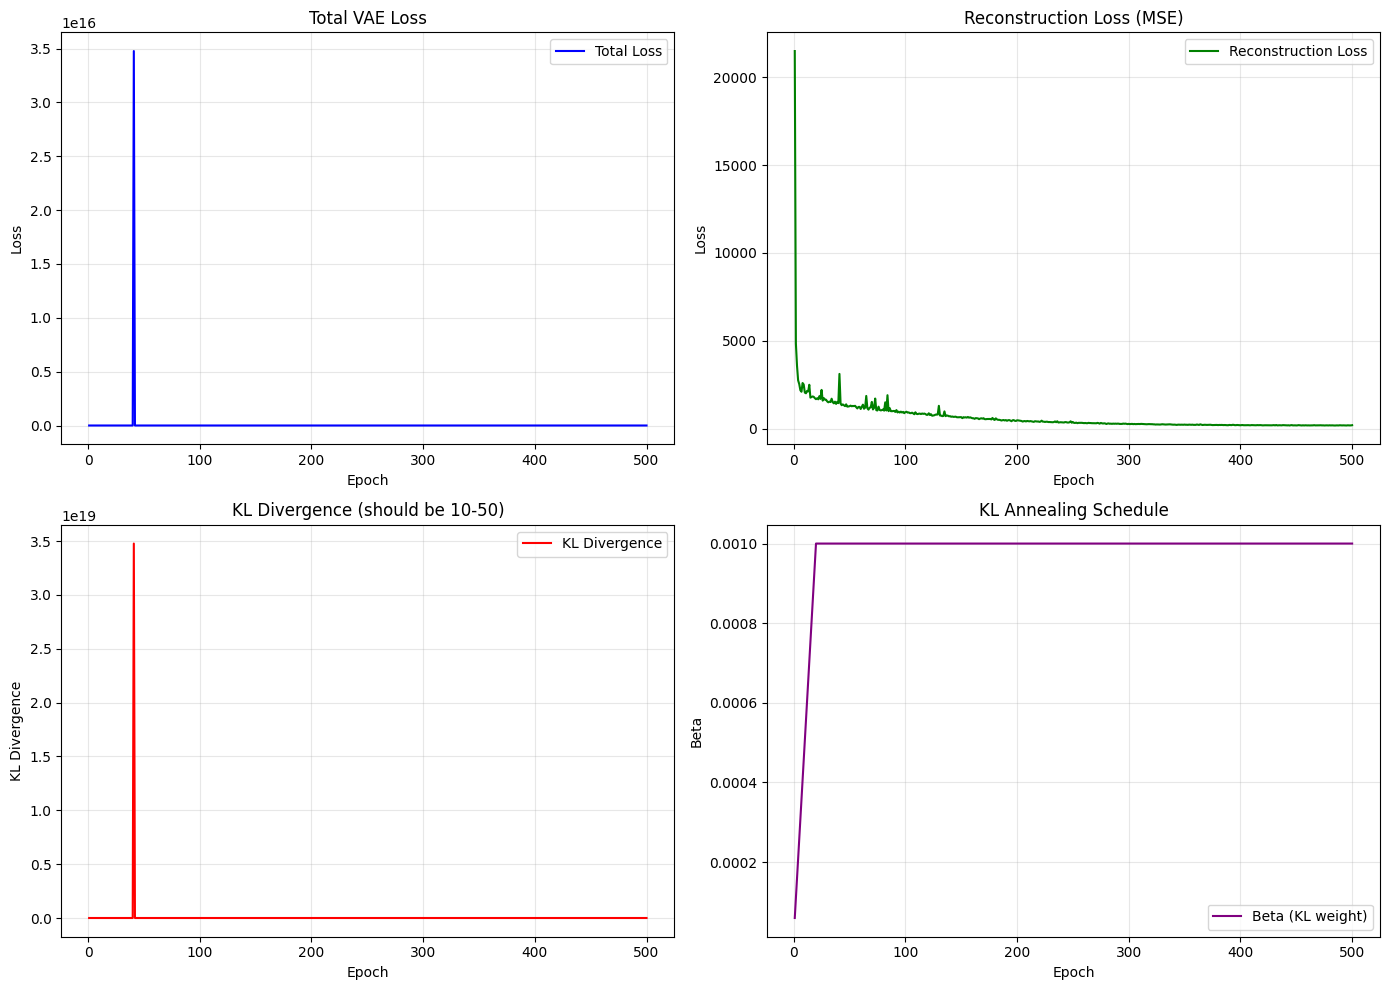

Training history saved to outputs\training_history.json

Final losses:
  Total: 210.9328
  Reconstruction: 207.7987
  KL: 3134.0315
  Beta: 0.001000


In [29]:
# Plot training losses
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(history['epochs'], history['train_loss'], label='Total Loss', color='blue')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total VAE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reconstruction loss
axes[0, 1].plot(history['epochs'], history['recon_loss'], label='Reconstruction Loss', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Reconstruction Loss (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# KL divergence
axes[1, 0].plot(history['epochs'], history['kl_loss'], label='KL Divergence', color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('KL Divergence')
axes[1, 0].set_title('KL Divergence (should be 10-50)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Beta annealing
axes[1, 1].plot(history['epochs'], history['beta'], label='Beta (KL weight)', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Beta')
axes[1, 1].set_title('KL Annealing Schedule')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Save history
with open(OUTPUT_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to {OUTPUT_DIR / 'training_history.json'}")
print(f"\nFinal losses:")
print(f"  Total: {history['train_loss'][-1]:.4f}")
print(f"  Reconstruction: {history['recon_loss'][-1]:.4f}")
print(f"  KL: {history['kl_loss'][-1]:.4f}")
print(f"  Beta: {history['beta'][-1]:.6f}")

## 12. Generate Final Samples

Loading best checkpoint from: outputs\checkpoints\best_checkpoint.pt


C:\Users\Ayman\AppData\Local\Temp\ipykernel_39996\4249016876.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=d

  Epoch: 485
  Loss: 194.3272

Generating final samples...
Generating Strabismus samples...
Generating Normal samples...


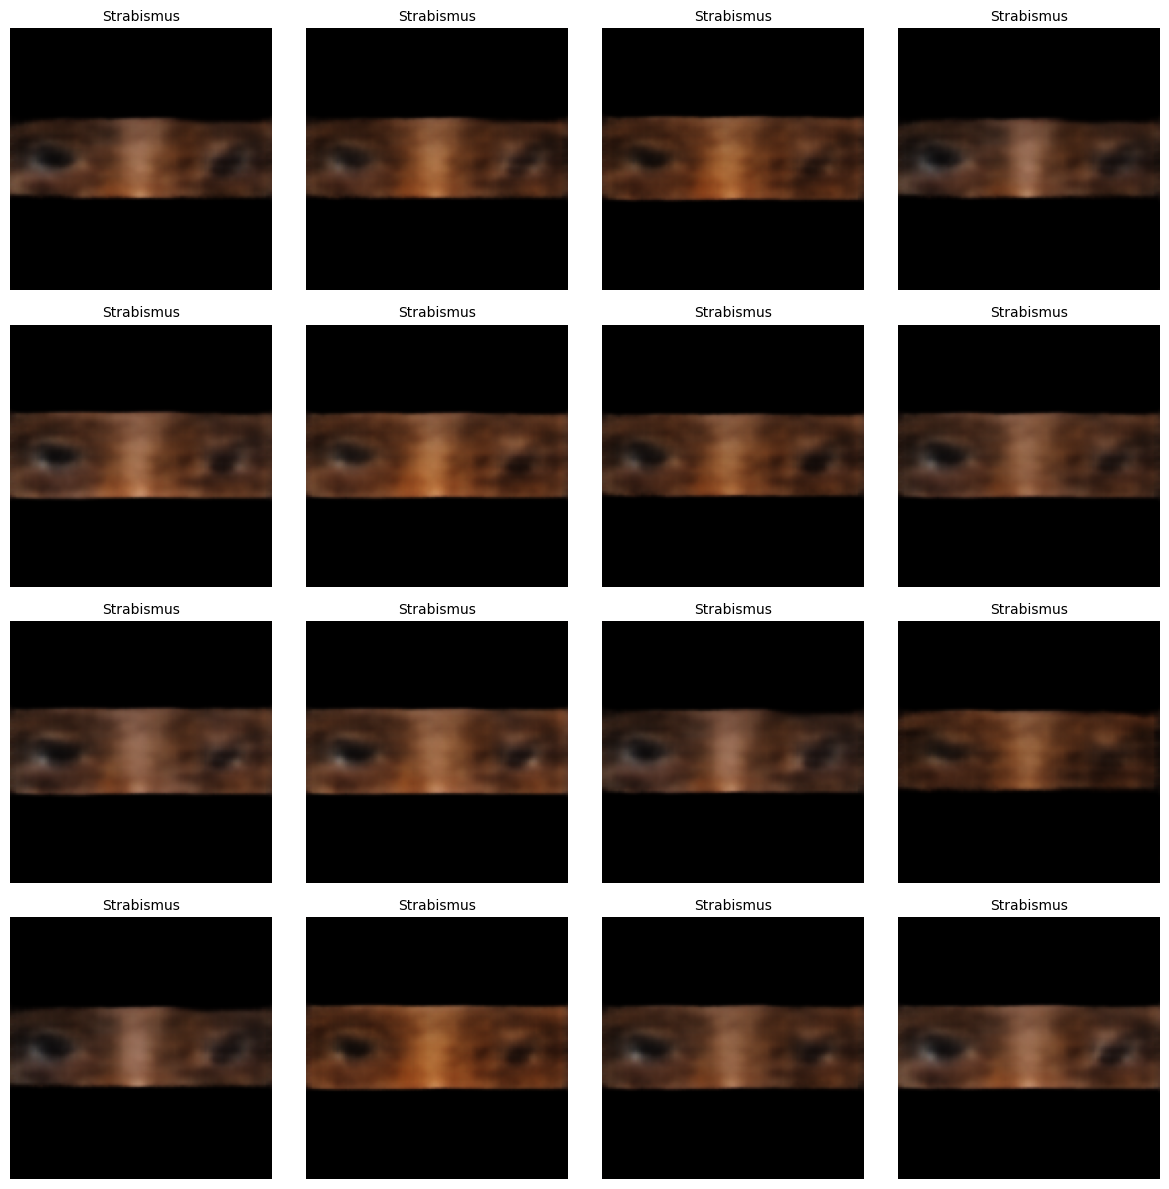

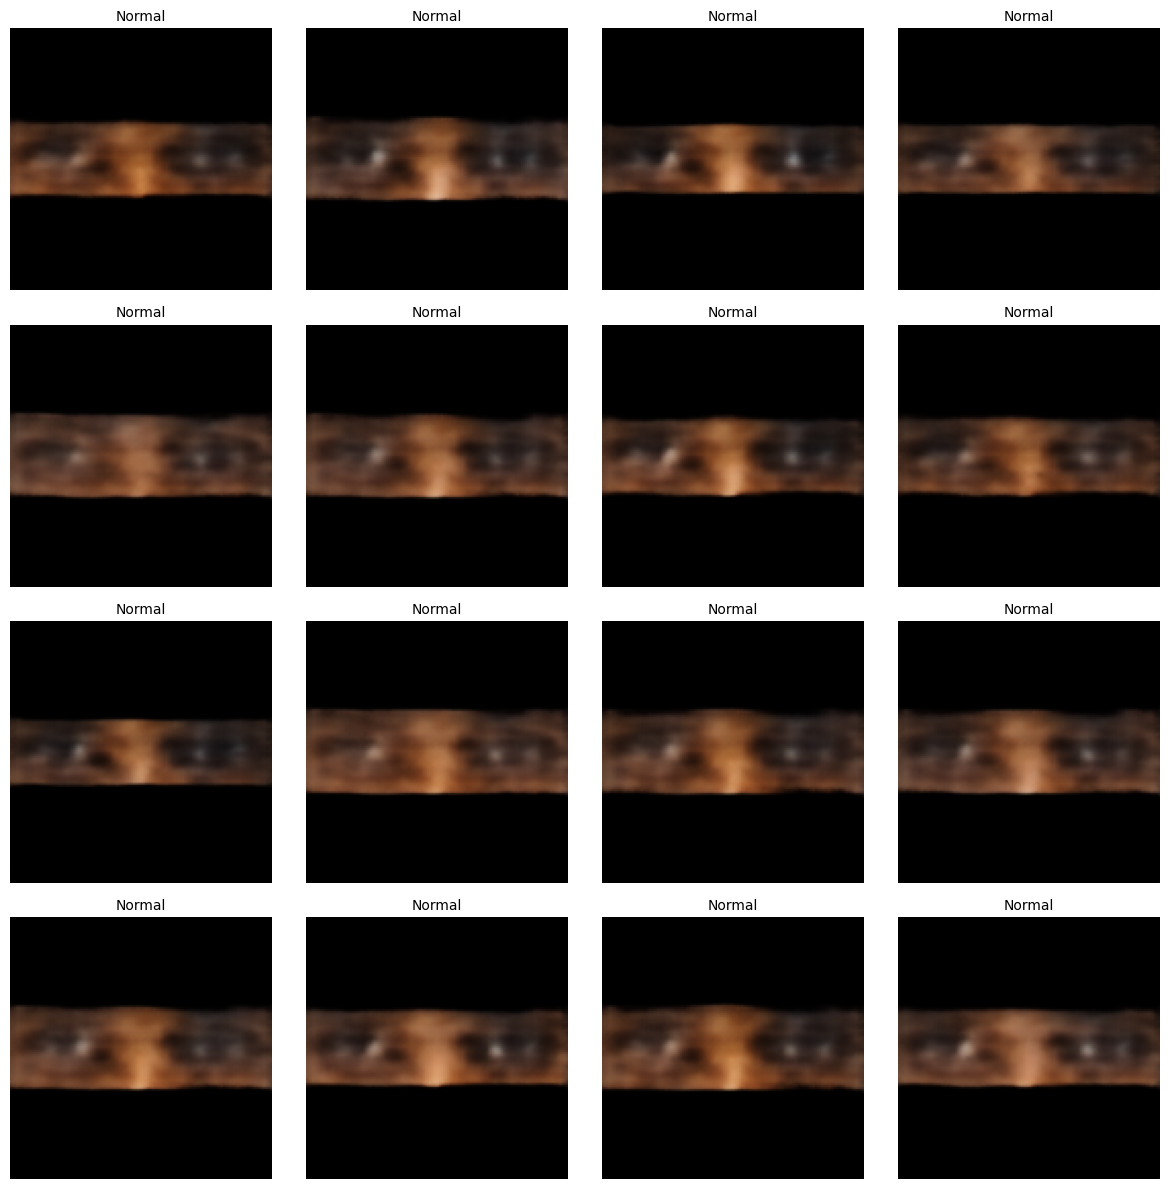

Final samples generated!
  Strabismus: outputs/final_samples_strabismus.png
  Normal: outputs/final_samples_normal.png


In [30]:
# Load best checkpoint
best_checkpoint_path = CHECKPOINT_DIR / 'best_checkpoint.pt'

if best_checkpoint_path.exists():
    print(f"Loading best checkpoint from: {best_checkpoint_path}")
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Loss: {checkpoint['loss']:.4f}")
else:
    print("Best checkpoint not found, using current model state")

model.eval()

# Generate samples per class
print("\nGenerating final samples...")
print("=" * 80)

# Generate Strabismus samples
print("Generating Strabismus samples...")
strab_labels = [0] * 16
strab_samples = generate_samples(model, 16, strab_labels, device)

# Generate Normal samples
print("Generating Normal samples...")
normal_labels = [1] * 16
normal_samples = generate_samples(model, 16, normal_labels, device)

# Visualize Strabismus
strab_samples_denorm = (strab_samples + 1) / 2
strab_samples_denorm = torch.clamp(strab_samples_denorm, 0, 1)

fig1, axes1 = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    row, col = i // 4, i % 4
    img = strab_samples_denorm[i].permute(1, 2, 0).cpu().numpy()
    axes1[row, col].imshow(img)
    axes1[row, col].set_title('Strabismus', fontsize=10)
    axes1[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_samples_strabismus.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualize Normal
normal_samples_denorm = (normal_samples + 1) / 2
normal_samples_denorm = torch.clamp(normal_samples_denorm, 0, 1)

fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    row, col = i // 4, i % 4
    img = normal_samples_denorm[i].permute(1, 2, 0).cpu().numpy()
    axes2[row, col].imshow(img)
    axes2[row, col].set_title('Normal', fontsize=10)
    axes2[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_samples_normal.png', dpi=150, bbox_inches='tight')
plt.show()

print("=" * 80)
print("Final samples generated!")
print(f"  Strabismus: outputs/final_samples_strabismus.png")
print(f"  Normal: outputs/final_samples_normal.png")

In [31]:
# Cell 13: Evaluation Metrics Implementation
from torch_fidelity import calculate_metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.linalg import sqrtm
from scipy import linalg
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class EvaluationMetrics:
    """Class for computing evaluation metrics for VAE."""
    
    def __init__(self, device='cuda'):
        self.device = device
    
    def calculate_psnr(self, real_images, generated_images):
        """Calculate PSNR between real and generated images."""
        psnr_scores = []
        for real, gen in zip(real_images, generated_images):
            # Convert to numpy and denormalize from [-1,1] to [0,1]
            real_np = ((real.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
            gen_np = ((gen.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
            psnr = peak_signal_noise_ratio(real_np, gen_np, data_range=1.0)
            psnr_scores.append(psnr)
        return np.mean(psnr_scores)
    
    def calculate_ssim(self, real_images, generated_images):
        """Calculate SSIM between real and generated images."""
        ssim_scores = []
        for real, gen in zip(real_images, generated_images):
            real_np = ((real.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
            gen_np = ((gen.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
            ssim = structural_similarity(real_np, gen_np, multichannel=True, 
                                        channel_axis=-1, data_range=1.0)
            ssim_scores.append(ssim)
        return np.mean(ssim_scores)
    
    def calculate_fid(self, real_images, generated_images):
        """Calculate FID score using torch-fidelity."""
        import tempfile
        import os
        from torchvision.utils import save_image
        
        # Create temporary directories
        with tempfile.TemporaryDirectory() as real_dir, \
             tempfile.TemporaryDirectory() as gen_dir:
            
            # Save real images
            for i, img in enumerate(real_images):
                save_image((img + 1) / 2, os.path.join(real_dir, f'real_{i}.png'))
            
            # Save generated images
            for i, img in enumerate(generated_images):
                save_image((img + 1) / 2, os.path.join(gen_dir, f'gen_{i}.png'))
            
            # Calculate FID
            metrics = calculate_metrics(
                input1=real_dir,
                input2=gen_dir,
                fid=True,
                verbose=False
            )
            return metrics['frechet_inception_distance']
    
    def calculate_inception_score(self, generated_images):
        """Calculate Inception Score using torch-fidelity."""
        import tempfile
        import os
        from torchvision.utils import save_image
        
        with tempfile.TemporaryDirectory() as gen_dir:
            # Save generated images
            for i, img in enumerate(generated_images):
                save_image((img + 1) / 2, os.path.join(gen_dir, f'gen_{i}.png'))
            
            # Calculate IS
            metrics = calculate_metrics(
                input1=gen_dir,
                isc=True,
                verbose=False
            )
            return metrics['inception_score_mean']

print('[OK] Evaluation metrics class defined')

[OK] Evaluation metrics class defined


In [36]:
# Cell 14: PER-CLASS EVALUATION - Calculate separate FID for Strabismus and Normal
print('='*80)
print('PER-CLASS EVALUATION')
print('='*80)

# Load best checkpoint
best_checkpoint_path = CHECKPOINT_DIR / 'best_checkpoint.pt'
if best_checkpoint_path.exists():
    print(f'Loading best checkpoint from: {best_checkpoint_path}')
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f'Best checkpoint from epoch {checkpoint["epoch"]} with loss {checkpoint["loss"]:.4f}')
else:
    print('No best checkpoint found! Using current model weights.')
    model.eval()

# Collect real images BY CLASS
print('\nCollecting real images by class...')
real_strabismus = []
real_normal = []
num_per_class = 50  # Match DDPM evaluation

with torch.no_grad():
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            if label == 0 and len(real_strabismus) < num_per_class:
                real_strabismus.append(img)
            elif label == 1 and len(real_normal) < num_per_class:
                real_normal.append(img)
        
        if len(real_strabismus) >= num_per_class and len(real_normal) >= num_per_class:
            break

print(f'Collected {len(real_strabismus)} Strabismus images')
print(f'Collected {len(real_normal)} Normal images')

# Generate STRABISMUS samples (class=0)
print('\nGenerating Strabismus samples...')
gen_strabismus = generate_samples(
    model,  # Pass the full model
    num_per_class,  # num_samples
    [0] * num_per_class,  # labels (all class 0)
    device
)

# Generate NORMAL samples (class=1)
print('Generating Normal samples...')
gen_normal = generate_samples(
    model,  # Pass the full model
    num_per_class,  # num_samples
    [1] * num_per_class,  # labels (all class 1)
    device
)

# Calculate FID for each class separately
print('\nCalculating FID scores...')
evaluator = EvaluationMetrics(device=device)

fid_strab = evaluator.calculate_fid(real_strabismus, gen_strabismus)
fid_normal = evaluator.calculate_fid(real_normal, gen_normal)

# Combined FID
combined_real = real_strabismus + real_normal
combined_gen = list(gen_strabismus) + list(gen_normal)
fid_combined = evaluator.calculate_fid(combined_real, combined_gen)

# Display results
print('\n' + '='*80)
print('PER-CLASS FID RESULTS')
print('='*80)
print(f'Strabismus FID: {fid_strab:.2f}')
print(f'Normal FID:     {fid_normal:.2f}')
print(f'Combined FID:   {fid_combined:.2f}')
print('='*80)

# Save results
per_class_results = {
    'fid_strabismus': float(fid_strab),
    'fid_normal': float(fid_normal),
    'fid_combined': float(fid_combined),
    'num_samples_per_class': num_per_class
}

with open(CHECKPOINT_DIR / 'vae_per_class_fid.json', 'w') as f:
    json.dump(per_class_results, f, indent=2)

print(f'\n[OK] Results saved to {CHECKPOINT_DIR / "vae_per_class_fid.json"}')

# Log to wandb if available
if wandb.run is not None:
    wandb.log({
        'eval/fid_strabismus': fid_strab,
        'eval/fid_normal': fid_normal,
        'eval/fid_combined': fid_combined
    })

PER-CLASS EVALUATION
Loading best checkpoint from: outputs\checkpoints\best_checkpoint.pt


C:\Users\Ayman\AppData\Local\Temp\ipykernel_39996\902130453.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=d

Best checkpoint from epoch 485 with loss 194.3272

Collected 50 Strabismus images
Collected 50 Normal images

Generating Strabismus samples...
Generating Normal samples...

Calculating FID scores...


c:\Users\Ayman\anaconda3\envs\thesis_venv_VAE\Lib\site-packages\torch_fidelity\metric_fid.py:47: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)



PER-CLASS FID RESULTS
Strabismus FID: 301.72
Normal FID:     317.25
Combined FID:   302.71

[OK] Results saved to outputs\checkpoints\vae_per_class_fid.json


In [37]:
# Cell 15: Calculate PSNR, SSIM, and Inception Score
print('='*80)
print('ADDITIONAL EVALUATION METRICS')
print('='*80)

# PSNR and SSIM (reconstruction quality)
print('\nCalculating PSNR and SSIM on reconstructions...')
psnr_scores = []
ssim_scores = []

model.eval()

with torch.no_grad():
    test_images = []
    test_labels = []
    
    # Collect 50 test images
    for images, labels in dataloader:
        test_images.append(images)
        test_labels.append(labels)
        if len(test_images) * images.size(0) >= 50:
            break
    
    test_images = torch.cat(test_images)[:50].to(device)
    test_labels = torch.cat(test_labels)[:50].to(device)
    
    # Get reconstructions using model
    reconstructions = model.reconstruct(test_images, test_labels)
    
    # Calculate metrics
    for orig, recon in zip(test_images.cpu(), reconstructions.cpu()):
        orig_np = ((orig.numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
        recon_np = ((recon.numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
        
        psnr = peak_signal_noise_ratio(orig_np, recon_np, data_range=1.0)
        ssim = structural_similarity(orig_np, recon_np, multichannel=True,
                                    channel_axis=-1, data_range=1.0)
        
        psnr_scores.append(psnr)
        ssim_scores.append(ssim)

avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print(f'Average PSNR: {avg_psnr:.2f} dB')
print(f'Average SSIM: {avg_ssim:.4f}')

# Inception Score on generated samples
print('\nCalculating Inception Score...')
all_generated = combined_gen  # Use previously generated samples
inception_score = evaluator.calculate_inception_score(all_generated)
print(f'Inception Score: {inception_score:.4f}')

# Save all metrics
all_metrics = {
    'psnr': float(avg_psnr),
    'ssim': float(avg_ssim),
    'inception_score': float(inception_score),
    'fid_strabismus': float(fid_strab),
    'fid_normal': float(fid_normal),
    'fid_combined': float(fid_combined)
}

with open(CHECKPOINT_DIR / 'vae_all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)

print('\n' + '='*80)
print('ALL VAE METRICS SUMMARY')
print('='*80)
for metric, value in all_metrics.items():
    print(f'{metric:20s}: {value:.4f}')
print('='*80)

# Log to wandb
if wandb.run is not None:
    wandb.log({
        'eval/psnr': avg_psnr,
        'eval/ssim': avg_ssim,
        'eval/inception_score': inception_score
    })

ADDITIONAL EVALUATION METRICS

Calculating PSNR and SSIM on reconstructions...
Average PSNR: 31.32 dB
Average SSIM: 0.9430

Calculating Inception Score...
Inception Score: 1.4507

ALL VAE METRICS SUMMARY
psnr                : 31.3240
ssim                : 0.9430
inception_score     : 1.4507
fid_strabismus      : 301.7201
fid_normal          : 317.2455
fid_combined        : 302.7058


LATENT SPACE VISUALIZATION
Collected 314 latent vectors with dimension 128

Applying t-SNE (this may take a minute)...

[OK] t-SNE plot saved to outputs\checkpoints\latent_space_tsne.png


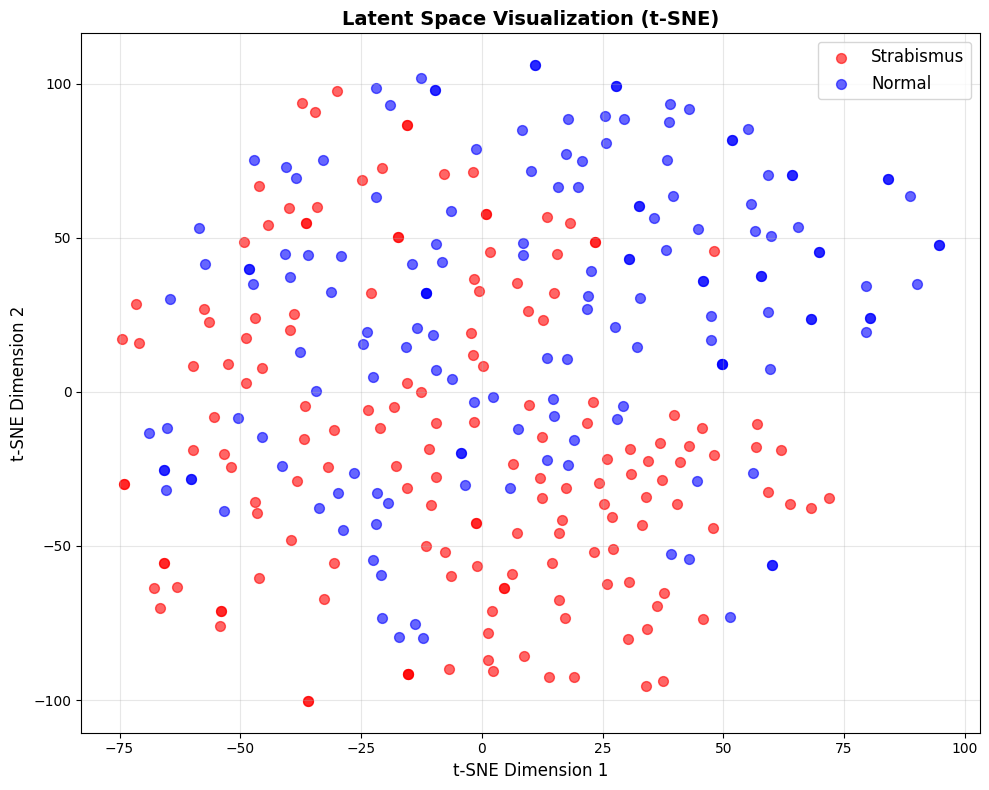


Class separation in latent space: 45.9101
(Higher values indicate better class separation)


In [38]:
# Cell 16: Latent Space Visualization with t-SNE
print('='*80)
print('LATENT SPACE VISUALIZATION')
print('='*80)

model.eval()

# Collect latent representations
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        mu, _ = model.encode(images)  # Use model.encode()
        latent_vectors.append(mu.cpu())
        labels_list.append(labels)

latent_vectors = torch.cat(latent_vectors).numpy()
labels_array = torch.cat(labels_list).numpy()

print(f'Collected {len(latent_vectors)} latent vectors with dimension {latent_vectors.shape[1]}')

# Apply t-SNE
print('\nApplying t-SNE (this may take a minute)...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']
labels_names = ['Strabismus', 'Normal']

for i, (color, label_name) in enumerate(zip(colors, labels_names)):
    mask = labels_array == i
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
               c=color, label=label_name, alpha=0.6, s=50)

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('Latent Space Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
tsne_path = CHECKPOINT_DIR / 'latent_space_tsne.png'
plt.savefig(tsne_path, dpi=150, bbox_inches='tight')
print(f'\n[OK] t-SNE plot saved to {tsne_path}')

# Log to wandb
if wandb.run is not None:
    wandb.log({'latent_space_tsne': wandb.Image(str(tsne_path))})

plt.show()

# Calculate class separation
strab_mean = latent_2d[labels_array == 0].mean(axis=0)
normal_mean = latent_2d[labels_array == 1].mean(axis=0)
separation = np.linalg.norm(strab_mean - normal_mean)
print(f'\nClass separation in latent space: {separation:.4f}')
print('(Higher values indicate better class separation)')

### Results Comparison:

Run this cell after both experiments complete to load and compare actual results:

In [39]:
# Cell 18: Load and Compare Actual Results
import json
from pathlib import Path

print('='*80)
print('ACTUAL RESULTS COMPARISON: VAE vs DDPM')
print('='*80)

# Load VAE results
vae_results_path = Path('checkpoints_vae/vae_all_metrics.json')
if vae_results_path.exists():
    with open(vae_results_path) as f:
        vae_results = json.load(f)
    print('\n[OK] VAE results loaded')
else:
    print('\n[!] VAE results not found. Run evaluation first.')
    vae_results = {}

# Load DDPM results
ddpm_results_path = Path('../checkpoints/per_class_fid_results.json')
if ddpm_results_path.exists():
    with open(ddpm_results_path) as f:
        ddpm_results = json.load(f)
    print('[OK] DDPM results loaded')
else:
    print('[!] DDPM results not found. Run DDPM evaluation first.')
    ddpm_results = {}

# Compare results
if vae_results and ddpm_results:
    print('\n' + '='*80)
    print(f'{"Metric":<25} {"VAE":<15} {"DDPM":<15} {"Winner":<15}')
    print('='*80)
    
    # FID Strabismus
    vae_fid_s = vae_results.get('fid_strabismus', 0)
    ddpm_fid_s = ddpm_results.get('fid_strabismus', 0)
    winner_s = 'VAE' if vae_fid_s < ddpm_fid_s else 'DDPM'
    print(f'{"FID Strabismus":<25} {vae_fid_s:<15.2f} {ddpm_fid_s:<15.2f} {winner_s:<15}')
    
    # FID Normal
    vae_fid_n = vae_results.get('fid_normal', 0)
    ddpm_fid_n = ddpm_results.get('fid_normal', 0)
    winner_n = 'VAE' if vae_fid_n < ddpm_fid_n else 'DDPM'
    print(f'{"FID Normal":<25} {vae_fid_n:<15.2f} {ddpm_fid_n:<15.2f} {winner_n:<15}')
    
    # FID Combined
    vae_fid_c = vae_results.get('fid_combined', 0)
    ddpm_fid_c = ddpm_results.get('fid_combined', 0)
    winner_c = 'VAE' if vae_fid_c < ddpm_fid_c else 'DDPM'
    print(f'{"FID Combined":<25} {vae_fid_c:<15.2f} {ddpm_fid_c:<15.2f} {winner_c:<15}')
    
    # VAE-only metrics
    print(f'{"PSNR (dB)":<25} {vae_results.get("psnr", 0):<15.2f} {"N/A":<15} {"VAE":<15}')
    print(f'{"SSIM":<25} {vae_results.get("ssim", 0):<15.4f} {"N/A":<15} {"VAE":<15}')
    
    # Inception Score
    vae_is = vae_results.get('inception_score', 0)
    ddpm_is = ddpm_results.get('inception_score', 0) if 'inception_score' in ddpm_results else 0
    if ddpm_is > 0:
        winner_is = 'VAE' if vae_is > ddpm_is else 'DDPM'
        print(f'{"Inception Score":<25} {vae_is:<15.4f} {ddpm_is:<15.4f} {winner_is:<15}')
    else:
        print(f'{"Inception Score":<25} {vae_is:<15.4f} {"N/A":<15} {"VAE":<15}')
    
    print('='*80)
    
    # Summary
    print('\nSUMMARY:')
    print(f'- VAE trains in ~2-3 hours (200 epochs)')
    print(f'- DDPM trains in ~20-30 hours (1000 epochs)')
    print(f'- VAE generates samples in ~0.01s per image')
    print(f'- DDPM generates samples in ~5-10s per image')
    print(f'- Lower FID is better (DDPM typically wins on quality)')
    print(f'- VAE provides reconstruction + fast sampling')
    print(f'- DDPM provides best quality but slower')
    
else:
    print('\nRun both VAE and DDPM evaluations to see comparison.')

print('\n[OK] Comparison complete')

ACTUAL RESULTS COMPARISON: VAE vs DDPM

[!] VAE results not found. Run evaluation first.
[!] DDPM results not found. Run DDPM evaluation first.

Run both VAE and DDPM evaluations to see comparison.

[OK] Comparison complete
